Êú¨Êñá‰∏ªË¶ÅÂèÇËÄÉÔºöhttp://fancyerii.github.io/2019/02/14/chatbot/

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

ÂÆûÁé∞Áî®seq2seqÊ®°ÂûãËÆ≠ÁªÉ‰∏Ä‰∏™chatbot„ÄÇ

‰ΩøÁî®ÁöÑËØ≠ÊñôÊù•Ëá™CornellÁîµÂΩ±ÁöÑÂØπËØùËØ≠ÊñôÂ∫ì



### Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [7]:
corpus = "./movie_corpus/"

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)
    
printLines(os.path.join(corpus, "movie_lines.txt"))
    

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [8]:
# ÊääÊØè‰∏ÄË°åÈÉΩparseÊàê‰∏Ä‰∏™dictÔºåkeyÊòØlineID„ÄÅcharacterID„ÄÅmovieID„ÄÅcharacterÂíåtext
# ÂàÜÂà´‰ª£Ë°®Ëøô‰∏ÄË°åÁöÑID„ÄÅ‰∫∫Áâ©ID„ÄÅÁîµÂΩ±IDÔºå‰∫∫Áâ©ÂêçÁß∞ÂíåÊñáÊú¨„ÄÇ
# ÊúÄÁªàËæìÂá∫‰∏Ä‰∏™dictÔºåkeyÊòØlineIDÔºåvalueÊòØ‰∏Ä‰∏™dict„ÄÇ
# valueËøô‰∏™dictÁöÑkeyÊòØlineID„ÄÅcharacterID„ÄÅmovieID„ÄÅcharacterÂíåtext
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # ÊäΩÂèñfields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines

In [9]:

# Ê†πÊçÆmovie_conversations.txtÊñá‰ª∂Âíå‰∏äËæìÂá∫ÁöÑlinesÔºåÊääutteranceÁªÑÊàêÂØπËØù„ÄÇ
# ÊúÄÁªàËæìÂá∫‰∏Ä‰∏™listÔºåËøô‰∏™listÁöÑÊØè‰∏Ä‰∏™ÂÖÉÁ¥†ÈÉΩÊòØ‰∏Ä‰∏™dictÔºå
# keyÂàÜÂà´ÊòØcharacter1ID„ÄÅcharacter2ID„ÄÅmovieIDÂíåutteranceIDs„ÄÇ
# ÂàÜÂà´Ë°®Á§∫ËøôÂØπËØùÁöÑÁ¨¨‰∏Ä‰∏™‰∫∫Áâ©ÁöÑIDÔºåÁ¨¨‰∫å‰∏™ÁöÑIDÔºåÁîµÂΩ±ÁöÑID‰ª•ÂèäÂÆÉÂåÖÂê´ÁöÑutteranceIDs
# ÊúÄÂêéÊ†πÊçÆlinesÔºåËøòÁªôÊØè‰∏ÄË°åÁöÑdictÂ¢ûÂä†‰∏Ä‰∏™key‰∏∫linesÔºåÂÖ∂valueÊòØ‰∏™listÔºå
# ÂåÖÂê´ÊâÄÊúâutterance(‰∏äÈù¢ÂæóÂà∞ÁöÑlinesÁöÑvalue)
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # ÊäΩÂèñfields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # convObj["utteranceIDs"]ÊòØ‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÔºåÂΩ¢Â¶Ç['L198', 'L199']
            # Êàë‰ª¨Áî®evalÊääËøô‰∏™Â≠óÁ¨¶‰∏≤ÂèòÊàê‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÁöÑlist„ÄÇ
            lineIds = eval(convObj["utteranceIDs"])
            # Ê†πÊçÆlineIdsÊûÑÈÄ†‰∏Ä‰∏™Êï∞ÁªÑÔºåÊ†πÊçÆlineIdÂéªlinesÈáåÊ£ÄÁ¥¢Âá∫Â≠òÂÇ®utteranceÂØπË±°„ÄÇ
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations

In [10]:
# ‰ªéÂØπËØù‰∏≠ÊäΩÂèñÂè•ÂØπ 
# ÂÅáËÆæ‰∏ÄÊÆµÂØπËØùÂåÖÂê´s1,s2,s3,s4Ëøô4‰∏™utterance
# ÈÇ£‰πà‰ºöËøîÂõû3‰∏™Âè•ÂØπÔºös1-s2,s2-s3Âíås3-s4„ÄÇ
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # ÈÅçÂéÜÂØπËØù‰∏≠ÁöÑÊØè‰∏Ä‰∏™Âè•Â≠êÔºåÂøΩÁï•ÊúÄÂêé‰∏Ä‰∏™Âè•Â≠êÔºåÂõ†‰∏∫Ê≤°ÊúâÁ≠îÊ°à„ÄÇ
        for i in range(len(conversation["lines"]) - 1): 
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Â¶ÇÊûúÊúâÁ©∫ÁöÑÂè•Â≠êÂ∞±ÂéªÊéâ 
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [11]:
# ÂÆö‰πâÊñ∞ÁöÑÊñá‰ª∂ 
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# ÂØπÂàÜÈöîÁ¨¶delimiterËøõË°ådecodeÔºåËøôÈáåÂØπtabËøõË°ådecodeÁªìÊûúÂπ∂Ê≤°ÊúâÂèò
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# ÂàùÂßãÂåñdict linesÔºålist conversations‰ª•ÂèäÂâçÈù¢Êàë‰ª¨‰ªãÁªçËøáÁöÑfieldÁöÑidÊï∞ÁªÑ„ÄÇ
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# È¶ñÂÖà‰ΩøÁî®loadLinesÂáΩÊï∞Â§ÑÁêÜmovie_lines.txt 
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
# Êé•ÁùÄ‰ΩøÁî®loadConversationsÂ§ÑÁêÜ‰∏ä‰∏ÄÊ≠•ÁöÑÁªìÊûúÔºåÂæóÂà∞conversations
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# ËæìÂá∫Âà∞‰∏Ä‰∏™Êñ∞ÁöÑcsvÊñá‰ª∂
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    # ‰ΩøÁî®extractSentencePairs‰ªéconversationsÈáåÊäΩÂèñÂè•ÂØπ„ÄÇ
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# ËæìÂá∫‰∏Ä‰∫õË°åÁî®‰∫éÊ£ÄÊü• 
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

‰∏äÈù¢ÁöÑ‰ª£Á†Å‰ºöÁîüÊàê‰∏Ä‰∏™Êñ∞ÁöÑÊñá‰ª∂formatted_movie_lines.txtÔºåËøôÊñá‰ª∂ÊØè‰∏ÄË°åÂåÖÂê´‰∏ÄÂØπÂè•ÂØπÔºåÁî®tabÂàÜÂâ≤„ÄÇ‰∏ãÈù¢ÊòØÂâçÂçÅË°åÔºö

### ÂàõÂª∫ËØçÂÖ∏

Êé•‰∏ãÊù•Êàë‰ª¨ÈúÄË¶ÅÊûÑÂª∫ËØçÂÖ∏ÁÑ∂ÂêéÊääÈóÆÁ≠îÂè•ÂØπÂä†ËΩΩÂà∞ÂÜÖÂ≠òÈáå„ÄÇ

Êàë‰ª¨ÁöÑËæìÂÖ•ÊòØ‰∏Ä‰∏™Âè•ÂØπÔºåÊØè‰∏™Âè•Â≠êÈÉΩÊòØËØçÁöÑÂ∫èÂàóÔºå‰ΩÜÊòØÊú∫Âô®Â≠¶‰π†Âè™ËÉΩÂ§ÑÁêÜÊï∞ÂÄºÔºåÂõ†Ê≠§Êàë‰ª¨ÈúÄË¶ÅÂª∫Á´ãËØçÂà∞Êï∞Â≠óIDÁöÑÊò†Â∞Ñ„ÄÇ

‰∏∫Ê≠§ÔºåÊàë‰ª¨‰ºöÂÆö‰πâ‰∏Ä‰∏™VocÁ±ªÔºåÂÆÉ‰ºö‰øùÂ≠òËØçÂà∞IDÁöÑÊò†Â∞ÑÔºåÂêåÊó∂‰πü‰øùÂ≠òÂèçÂêëÁöÑ‰ªéIDÂà∞ËØçÁöÑÊò†Â∞Ñ„ÄÇ

Èô§Ê≠§‰πãÂ§ñÔºåÂÆÉËøòËÆ∞ÂΩïÊØè‰∏™ËØçÂá∫Áé∞ÁöÑÊ¨°Êï∞Ôºå‰ª•ÂèäÊÄªÂÖ±Âá∫Áé∞ÁöÑËØçÁöÑ‰∏™Êï∞„ÄÇËøô‰∏™Á±ªÊèê‰æõaddWordÊñπÊ≥ïÊù•Â¢ûÂä†‰∏Ä‰∏™ËØçÔºå addSentenceÊñπÊ≥ïÊù•Â¢ûÂä†Âè•Â≠êÔºå‰πüÊèê‰æõÊñπÊ≥ïtrimÊù•ÂéªÈô§‰ΩéÈ¢ëÁöÑËØç„ÄÇ

In [12]:
# È¢ÑÂÆö‰πâÁöÑtoken
PAD_token = 0  # Ë°®Á§∫padding 
SOS_token = 1  # Âè•Â≠êÁöÑÂºÄÂßã 
EOS_token = 2  # Âè•Â≠êÁöÑÁªìÊùü 

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # ÁõÆÂâçÊúâSOS, EOS, PADËøô3‰∏™token„ÄÇ

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Âà†Èô§È¢ëÊ¨°Â∞è‰∫émin_countÁöÑtoken 
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # ÈáçÊñ∞ÊûÑÈÄ†ËØçÂÖ∏ 
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens
        
        # ÈáçÊñ∞ÊûÑÈÄ†ÂêéËØçÈ¢ëÂ∞±Ê≤°ÊúâÊÑè‰πâ‰∫Ü(ÈÉΩÊòØ1)
        for word in keep_words:
            self.addWord(word)

Êúâ‰∫Ü‰∏äÈù¢ÁöÑVocÁ±ªÊàë‰ª¨Â∞±ÂèØ‰ª•ÈÄöËøáÈóÆÁ≠îÂè•ÂØπÊù•ÊûÑÂª∫ËØçÂÖ∏‰∫Ü„ÄÇ‰ΩÜÊòØÂú®ÊûÑÂª∫‰πãÂâçÊàë‰ª¨ÈúÄË¶ÅËøõË°å‰∏Ä‰∫õÈ¢ÑÂ§ÑÁêÜ„ÄÇ

È¶ñÂÖàÊàë‰ª¨ÈúÄË¶Å‰ΩøÁî®ÂáΩÊï∞unicodeToAsciiÊù•ÊääunicodeÂ≠óÁ¨¶ÂèòÊàêasciiÔºåÊØîÂ¶ÇÊää√†ÂèòÊàêa„ÄÇ

Ê≥®ÊÑèÔºåËøôÈáåÁöÑ‰ª£Á†ÅÂè™ÊòØÁî®‰∫éÂ§ÑÁêÜË•øÊñπÊñáÂ≠óÔºåÂ¶ÇÊûúÊòØ‰∏≠ÊñáÔºåËøô‰∏™ÂáΩÊï∞Áõ¥Êé•‰ºö‰∏¢ÂºÉÊéâ„ÄÇ
Êé•‰∏ãÊù•ÊääÊâÄÊúâÂ≠óÊØçÂèòÊàêÂ∞èÂÜôÂêåÊó∂‰∏¢ÂºÉÊéâÂ≠óÊØçÂíåÂ∏∏ËßÅÊ†áÁÇπ(.!?)‰πãÂ§ñÁöÑÊâÄÊúâÂ≠óÁ¨¶„ÄÇ

ÊúÄÂêé‰∏∫‰∫ÜËÆ≠ÁªÉÊî∂ÊïõÔºåÊàë‰ª¨‰ºöÁî®ÂáΩÊï∞filterPairsÂéªÊéâÈïøÂ∫¶Ë∂ÖËøáMAX_LENGTHÁöÑÂè•Â≠ê(Âè•ÂØπ)„ÄÇ

In [13]:
MAX_LENGTH = 10  # Âè•Â≠êÊúÄÂ§ßÈïøÂ∫¶ÊòØ10‰∏™ËØç(ÂåÖÊã¨EOSÁ≠âÁâπÊÆäËØç)

# ÊääUnicodeÂ≠óÁ¨¶‰∏≤ÂèòÊàêASCII
# ÂèÇËÄÉhttps://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
 
def normalizeString(s):
    # ÂèòÊàêÂ∞èÂÜô„ÄÅÂéªÊéâÂâçÂêéÁ©∫Ê†ºÔºåÁÑ∂ÂêéunicodeÂèòÊàêascii
    s = unicodeToAscii(s.lower().strip())
    # Âú®Ê†áÁÇπÂâçÂ¢ûÂä†Á©∫Ê†ºÔºåËøôÊ†∑ÊääÊ†áÁÇπÂΩìÊàê‰∏Ä‰∏™ËØç
    s = re.sub(r"([.!?])", r" \1", s)
    # Â≠óÊØçÂíåÊ†áÁÇπ‰πãÂ§ñÁöÑÂ≠óÁ¨¶ÈÉΩÂèòÊàêÁ©∫Ê†º
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    # Âõ†‰∏∫Êää‰∏çÁî®ÁöÑÂ≠óÁ¨¶ÈÉΩÂèòÊàêÁ©∫Ê†ºÔºåÊâÄ‰ª•ÂèØËÉΩÂ≠òÂú®Â§ö‰∏™ËøûÁª≠Á©∫Ê†º
    # ‰∏ãÈù¢ÁöÑÊ≠£ÂàôÊõøÊç¢ÊääÂ§ö‰∏™Á©∫Ê†ºÂèòÊàê‰∏Ä‰∏™Á©∫Ê†ºÔºåÊúÄÂêéÂéªÊéâÂâçÂêéÁ©∫Ê†º
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# ËØªÂèñÈóÆÁ≠îÂè•ÂØπÂπ∂‰∏îËøîÂõûVocËØçÂÖ∏ÂØπË±° 
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Êñá‰ª∂ÊØèË°åËØªÂèñÂà∞list lines‰∏≠„ÄÇ 
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # ÊØèË°åÁî®tabÂàáÂàÜÊàêÈóÆÁ≠î‰∏§‰∏™Âè•Â≠êÔºåÁÑ∂ÂêéË∞ÉÁî®normalizeStringÂáΩÊï∞ËøõË°åÂ§ÑÁêÜ„ÄÇ
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

def filterPair(p): 
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# ËøáÊª§Â§™ÈïøÁöÑÂè•ÂØπ 
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# ‰ΩøÁî®‰∏äÈù¢ÁöÑÂáΩÊï∞ËøõË°åÂ§ÑÁêÜÔºåËøîÂõûVocÂØπË±°ÂíåÂè•ÂØπÁöÑlist 
def loadPrepareData(corpus, corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
# save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile)
# ËæìÂá∫‰∏Ä‰∫õÂè•ÂØπ
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


Êàë‰ª¨ÂèØ‰ª•ÁúãÂà∞ÔºåÂéüÊù•ÂÖ±Êúâ221282‰∏™Âè•ÂØπÔºåÁªèËøáÂ§ÑÁêÜÂêéÊàë‰ª¨Âè™‰øùÁïô‰∫Ü64271‰∏™Âè•ÂØπ„ÄÇ

Âè¶Â§ñ‰∏∫‰∫ÜÊî∂ÊïõÊõ¥Âø´ÔºåÊàë‰ª¨ÂèØ‰ª•ÂéªÈô§Êéâ‰∏Ä‰∫õ‰ΩéÈ¢ëËØç„ÄÇËøôÂèØ‰ª•ÂàÜ‰∏∫‰∏§Ê≠•Ôºö

1) ‰ΩøÁî®voc.trimÂáΩÊï∞ÂéªÊéâÈ¢ëÊ¨°‰Ωé‰∫éMIN_COUNT ÁöÑËØç„ÄÇ

2) ÂéªÊéâÂåÖÂê´‰ΩéÈ¢ëËØçÁöÑÂè•Â≠ê(Âè™‰øùÁïôËøôÊ†∑ÁöÑÂè•Â≠ê‚Äî‚ÄîÊØè‰∏Ä‰∏™ËØçÈÉΩÊòØÈ´òÈ¢ëÁöÑÔºå‰πüÂ∞±ÊòØÂú®voc‰∏≠Âá∫Áé∞ÁöÑ)

In [14]:
MIN_COUNT = 3    # ÈòàÂÄº‰∏∫3


def trimRareWords(voc, pairs, MIN_COUNT):
    # ÂéªÊéâvoc‰∏≠È¢ëÊ¨°Â∞è‰∫é3ÁöÑËØç 
    voc.trim(MIN_COUNT)
    # ‰øùÁïôÁöÑÂè•ÂØπ 
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Ê£ÄÊü•ÈóÆÈ¢ò
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Ê£ÄÊü•Á≠îÊ°à
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Â¶ÇÊûúÈóÆÈ¢òÂíåÁ≠îÊ°àÈÉΩÂè™ÂåÖÂê´È´òÈ¢ëËØçÔºåÊàë‰ª¨Êâç‰øùÁïôËøô‰∏™Âè•ÂØπ
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), 
		len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# ÂÆûÈôÖËøõË°åÂ§ÑÁêÜ
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


18005‰∏™ËØç‰πã‰∏≠ÔºåÈ¢ëÊ¨°Â§ß‰∫éÁ≠â‰∫é3ÁöÑÂè™Êúâ43%ÔºåÂéªÊéâ‰ΩéÈ¢ëÁöÑ57%ÁöÑËØç‰πãÂêéÔºå‰øùÁïôÁöÑÂè•Â≠ê‰∏∫53165ÔºåÂç†ÊØî‰∏∫82%

# ‰∏∫Ê®°ÂûãÂáÜÂ§áÊï∞ÊçÆ

ÂâçÈù¢Êàë‰ª¨ÊûÑÂª∫‰∫ÜËØçÂÖ∏ÔºåÂπ∂‰∏îÂØπËÆ≠ÁªÉÊï∞ÊçÆËøõË°åÈ¢ÑÂ§ÑÁêÜÂπ∂‰∏îÊª§Êéâ‰∏Ä‰∫õÂè•ÂØπÔºå‰ΩÜÊòØÊ®°ÂûãÊúÄÁªàÁî®Âà∞ÁöÑÊòØTensor„ÄÇ

ÊúÄÁÆÄÂçïÁöÑÂäûÊ≥ïÊòØ‰∏ÄÊ¨°Â§ÑÁêÜ‰∏Ä‰∏™Âè•ÂØπÔºåÈÇ£‰πà‰∏äÈù¢ÂæóÂà∞ÁöÑÂè•ÂØπÁõ¥Êé•Â∞±ÂèØ‰ª•‰ΩøÁî®„ÄÇ‰ΩÜÊòØ‰∏∫‰∫ÜÂä†Âø´ËÆ≠ÁªÉÈÄüÂ∫¶ÔºåÂ∞§ÂÖ∂ÊòØÈáçÂ§çÂà©Áî®GPUÁöÑÂπ∂Ë°åËÉΩÂäõÔºåÊàë‰ª¨ÈúÄË¶Å‰∏ÄÊ¨°Â§ÑÁêÜ‰∏Ä‰∏™batchÁöÑÊï∞ÊçÆ„ÄÇ


Âõ†Ê≠§Êàë‰ª¨ÈÄöÂ∏∏‰ºö‰ΩøÁî®PaddingÁöÑÊäÄÂ∑ßÔºåÊääÁü≠ÁöÑÂè•Â≠êË°•ÂÖÖ‰∏äÈõ∂‰ΩøÂæóËæìÂÖ•Â§ßÂ∞èÊòØ(batch, max_length)ÔºåËøôÊ†∑ÈÄöËøá‰∏ÄÊ¨°Â∞±ËÉΩÂÆûÁé∞‰∏Ä‰∏™batchÊï∞ÊçÆÁöÑforwardÊàñËÄÖbackwardËÆ°ÁÆó„ÄÇ

ÂΩìÁÑ∂paddingÁöÑÈÉ®ÂàÜÁöÑÁªìÊûúÊòØÊ≤°ÊúâÊÑè‰πâÁöÑÔºåÊØîÂ¶ÇÊüê‰∏™Âè•Â≠êÂÆûÈôÖÈïøÂ∫¶ÊòØ5ÔºåËÄåmax_lengthÊòØ10ÔºåÈÇ£‰πàÊúÄÁªàforwardÁöÑËæìÂá∫Â∫îËØ•ÊòØÁ¨¨5‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÔºåÂêéÈù¢5‰∏™Êó∂ÂàªËÆ°ÁÆóÊòØÊó†Áî®Âäü„ÄÇÊñπÂêëËÆ°ÁÆóÊ¢ØÂ∫¶ÁöÑÊó∂ÂÄô‰πüÊòØÁ±ª‰ººÁöÑÔºåÊàë‰ª¨ÈúÄË¶Å‰ªéÁ¨¨5‰∏™Êó∂ÂàªÂºÄÂßãÂèçÂêëËÆ°ÁÆóÊ¢ØÂ∫¶„ÄÇ

‰∏∫‰∫ÜÊèêÈ´òÊïàÁéáÔºåÊàë‰ª¨ÈÄöÂ∏∏ÊääÈïøÂ∫¶Êé•ËøëÁöÑËÆ≠ÁªÉÊï∞ÊçÆÊîæÂà∞‰∏Ä‰∏™batchÈáåÈù¢ÔºåËøôÊ†∑Êó†Áî®ÁöÑËÆ°ÁÆóÊòØÊúÄÂ∞ëÁöÑ„ÄÇ

Âõ†Ê≠§Êàë‰ª¨ÈÄöÂ∏∏ÊääÂÖ®ÈÉ®ËÆ≠ÁªÉÊï∞ÊçÆÊ†πÊçÆÈïøÂ∫¶ÂàíÂàÜÊàê‰∏Ä‰∫õÁªÑÔºåÊØîÂ¶ÇÈïøÂ∫¶Â∞è‰∫é4ÁöÑ‰∏ÄÁªÑÔºåÈïøÂ∫¶4Âà∞8ÁöÑ‰∏ÄÁªÑÔºåÈïøÂ∫¶8Âà∞12ÁöÑ‰∏ÄÁªÑÔºå‚Ä¶„ÄÇÁÑ∂ÂêéÊØèÊ¨°ÈöèÊú∫ÁöÑÈÄâÊã©‰∏Ä‰∏™ÁªÑÔºåÂÜçÈöèÊú∫ÁöÑ‰ªé‰∏ÄÁªÑÈáåÈÄâÊã©batch‰∏™Êï∞ÊçÆ„ÄÇ‰∏çËøáÊú¨ÊïôÁ®ãÂπ∂Ê≤°ÊúâËøô‰πàÂÅöÔºåËÄåÊòØÊØèÊ¨°ÈöèÊú∫ÁöÑ‰ªéÊâÄÊúâpairÈáåÈöèÊú∫ÈÄâÊã©batch‰∏™Êï∞ÊçÆ„ÄÇ

ÂéüÂßãÁöÑËæìÂÖ•ÈÄöÂ∏∏ÊòØbatch‰∏™listÔºåË°®Á§∫batch‰∏™Âè•Â≠êÔºåÂõ†Ê≠§Ëá™ÁÑ∂ÁöÑË°®Á§∫ÊñπÊ≥ï‰∏∫(batch, max_length)ÔºåËøôÁßçË°®Á§∫ÊñπÊ≥ïÁ¨¨‰∏ÄÁª¥ÊòØbatchÔºåÊØèÁßªÂä®‰∏Ä‰∏™‰∏ãÊ†áÂæóÂà∞ÁöÑÊòØ‰∏Ä‰∏™Ê†∑Êú¨ÁöÑmax_length‰∏™ËØç(ÂåÖÊã¨padding)„ÄÇ

Âõ†‰∏∫RNNÁöÑ‰æùËµñÂÖ≥Á≥ªÔºåÊàë‰ª¨Âú®ËÆ°ÁÆót+1Êó∂ÂàªÂøÖÈ°ªÁü•ÈÅìtÊó∂ÂàªÁöÑÁªìÊûúÔºåÂõ†Ê≠§Êàë‰ª¨Êó†Ê≥ïÁî®Â§ö‰∏™Ê†∏ÂêåÊó∂ËÆ°ÁÆó‰∏Ä‰∏™Ê†∑Êú¨ÁöÑforward„ÄÇ‰ΩÜÊòØ‰∏çÂêåÊ†∑Êú¨‰πãÈó¥ÊòØÊ≤°Êúâ‰æùËµñÂÖ≥Á≥ªÁöÑÔºåÂõ†Ê≠§Êàë‰ª¨ÂèØ‰ª•Âú®Ê†πÊçÆtÊó∂ÂàªbatchÊ†∑Êú¨ÁöÑÂΩìÂâçÁä∂ÊÄÅËÆ°ÁÆóbatch‰∏™Ê†∑Êú¨ÁöÑËæìÂá∫ÂíåÊñ∞Áä∂ÊÄÅÔºåÁÑ∂ÂêéÂÜçËÆ°ÁÆót+2Êó∂ÂàªÔºå‚Ä¶„ÄÇ

‰∏∫‰∫Ü‰æø‰∫éGPU‰∏ÄÊ¨°ÂèñÂá∫tÊó∂ÂàªÁöÑbatch‰∏™Êï∞ÊçÆÔºåÊàë‰ª¨ÈÄöÂ∏∏ÊääËæìÂÖ•‰ªé(batch, max_length)ÂèòÊàê(max_length, batch)ÔºåËøôÊ†∑‰ΩøÂæótÊó∂ÂàªÁöÑbatch‰∏™Êï∞ÊçÆÂú®ÂÜÖÂ≠ò(ÊòæÂ≠ò)‰∏≠ÊòØËøûÁª≠ÁöÑÔºå‰ªéËÄåËØªÂèñÊïàÁéáÊõ¥È´ò„ÄÇ

Ëøô‰∏™ËøáÁ®ãÂ¶Ç‰∏ãÂõæÊâÄÁ§∫ÔºåÂéüÂßãËæìÂÖ•ÁöÑÂ§ßÂ∞èÊòØ(batch=6, max_length=4)ÔºåËΩ¨ÁΩÆ‰πãÂêéÂèòÊàê(4,6)„ÄÇËøôÊ†∑Êüê‰∏™Êó∂ÂàªÁöÑ6‰∏™Ê†∑Êú¨Êï∞ÊçÆÂú®ÂÜÖÂ≠ò‰∏≠ÊòØËøûÁª≠ÁöÑ„ÄÇ

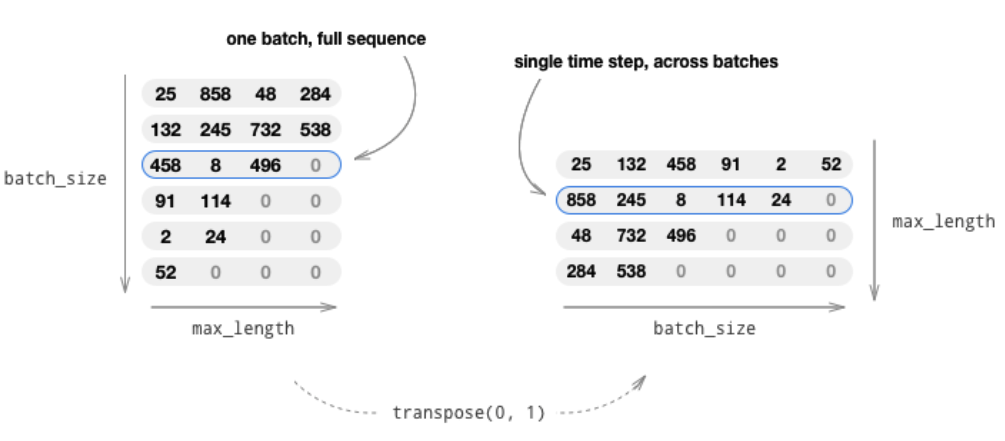

In [20]:
from IPython.display import Image
Image(filename="./figure/1.png", width=800, height=800)

 Âõ†Ê≠§Êàë‰ª¨‰ºöÁî®‰∏Ä‰∫õÂ∑•ÂÖ∑ÂáΩÊï∞Êù•ÂÆûÁé∞‰∏äËø∞Â§ÑÁêÜ„ÄÇ

inputVarÂáΩÊï∞Êääbatch‰∏™Âè•Â≠êpaddingÂêéÂèòÊàê‰∏Ä‰∏™LongTensorÔºåÂ§ßÂ∞èÊòØ(max_length, batch)ÔºåÂêåÊó∂‰ºöËøîÂõû‰∏Ä‰∏™Â§ßÂ∞èÊòØbatchÁöÑlist lengthsÔºåËØ¥ÊòéÊØè‰∏™Âè•Â≠êÁöÑÂÆûÈôÖÈïøÂ∫¶ÔºåËøô‰∏™ÂèÇÊï∞ÂêéÈù¢‰ºö‰º†ÁªôPyTorchÔºå‰ªéËÄåÂú®forwardÂíåbackwardËÆ°ÁÆóÁöÑÊó∂ÂÄô‰ΩøÁî®ÂÆûÈôÖÁöÑÈïøÂ∫¶„ÄÇ

outputVarÂáΩÊï∞ÂíåinputVarÁ±ª‰ººÔºå‰ΩÜÊòØÂÆÉËæìÂá∫ÁöÑÁ¨¨‰∫å‰∏™ÂèÇÊï∞‰∏çÊòØlengthsÔºåËÄåÊòØ‰∏Ä‰∏™Â§ßÂ∞è‰∏∫(max_length, batch)ÁöÑmaskÁü©Èòµ(tensor)ÔºåÊüê‰ΩçÊòØ0Ë°®Á§∫Ëøô‰∏™‰ΩçÁΩÆÊòØpaddingÔºå1Ë°®Á§∫‰∏çÊòØpaddingÔºåËøôÊ†∑ÂÅöÁöÑÁõÆÁöÑÊòØÂêéÈù¢ËÆ°ÁÆóÊñπ‰æø„ÄÇÂΩìÁÑ∂Ëøô‰∏§ÁßçË°®Á§∫ÊòØÁ≠â‰ª∑ÁöÑÔºåÂè™‰∏çËøálengthsË°®Á§∫Êõ¥Âä†Á¥ßÂáëÔºå‰ΩÜÊòØËÆ°ÁÆóËµ∑Êù•‰∏çÂêåÊñπ‰æøÔºåËÄåmaskÁü©ÈòµÂíåoutputVarÁõ¥Êé•Áõ∏‰πòÂ∞±ÂèØ‰ª•ÊääpaddingÁöÑ‰ΩçÁΩÆÁªômask(ÂèòÊàê0)ÊéâÔºåËøôÂú®ËÆ°ÁÆólossÊó∂‰ºöÈùûÂ∏∏Êñπ‰æø„ÄÇ

batch2TrainData ÂàôÂà©Áî®‰∏äÈù¢ÁöÑ‰∏§‰∏™ÂáΩÊï∞Êää‰∏Ä‰∏™batchÁöÑÂè•ÂØπÂ§ÑÁêÜÊàêÂêàÈÄÇÁöÑËæìÂÖ•ÂíåËæìÂá∫Tensor„ÄÇ



In [15]:
# ÊääÂè•Â≠êÁöÑËØçÂèòÊàêID
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

# lÊòØÂ§ö‰∏™ÈïøÂ∫¶‰∏çÂêåÂè•Â≠ê(list)Ôºå‰ΩøÁî®zip_longest paddingÊàêÂÆöÈïøÔºåÈïøÂ∫¶‰∏∫ÊúÄÈïøÂè•Â≠êÁöÑÈïøÂ∫¶„ÄÇ
def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

# lÊòØ‰∫åÁª¥ÁöÑpaddingÂêéÁöÑlist
# ËøîÂõûmÂíålÁöÑÂ§ßÂ∞è‰∏ÄÊ†∑ÔºåÂ¶ÇÊûúÊüê‰∏™‰ΩçÁΩÆÊòØpaddingÔºåÈÇ£‰πàÂÄº‰∏∫0ÔºåÂê¶Âàô‰∏∫1
def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# ÊääËæìÂÖ•Âè•Â≠êÂèòÊàêIDÔºåÁÑ∂ÂêéÂÜçpaddingÔºåÂêåÊó∂ËøîÂõûlengthsËøô‰∏™listÔºåÊ†áËØÜÂÆûÈôÖÈïøÂ∫¶„ÄÇ
# ËøîÂõûÁöÑpadVarÊòØ‰∏Ä‰∏™LongTensorÔºåshapeÊòØ(batch, max_length)Ôºå
# lengthsÊòØ‰∏Ä‰∏™listÔºåÈïøÂ∫¶‰∏∫(batch,)ÔºåË°®Á§∫ÊØè‰∏™Âè•Â≠êÁöÑÂÆûÈôÖÈïøÂ∫¶„ÄÇ
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# ÂØπËæìÂá∫Âè•Â≠êËøõË°åpaddingÔºåÁÑ∂ÂêéÁî®binaryMatrixÂæóÂà∞ÊØè‰∏™‰ΩçÁΩÆÊòØpadding(0)ËøòÊòØÈùûpaddingÔºå
# ÂêåÊó∂ËøîÂõûÊúÄÂ§ßÊúÄÈïøÂè•Â≠êÁöÑÈïøÂ∫¶(‰πüÂ∞±ÊòØpaddingÂêéÁöÑÈïøÂ∫¶)
# ËøîÂõûÂÄºpadVarÊòØLongTensorÔºåshapeÊòØ(batch, max_target_length)
# maskÊòØByteTensorÔºåshape‰πüÊòØ(batch, max_target_length)
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Â§ÑÁêÜ‰∏Ä‰∏™batchÁöÑpairÂè•ÂØπ 
def batch2TrainData(voc, pair_batch):
    # ÊåâÁÖßÂè•Â≠êÁöÑÈïøÂ∫¶(ËØçÊï∞)ÊéíÂ∫è
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Á§∫‰æã
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)


input_variable: tensor([[ 147,   94,  318, 4475, 3138],
        [  68,  117,   38, 4477,   76],
        [   7,  746,  266,    6,    6],
        [  24,   53,    2,    2,    2],
        [  25, 3314,    0,    0,    0],
        [ 102,    4,    0,    0,    0],
        [ 159,    2,    0,    0,    0],
        [   6,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([9, 7, 4, 4, 4])
target_variable: tensor([[6324,   64,   27,    7,   25],
        [ 279, 3568,   94, 1004,  348],
        [  83,   68,  542,  315,   25],
        [   4,   45,    2,   36,  534],
        [   2,   95,    0,    6, 4430],
        [   0,  138,    0,    2,  135],
        [   0,  886,    0,    0,    2],
        [   0, 3314,    0,    0,    0],
        [   0,    4,    0,    0,    0],
        [   0,    2,    0,    0,    0]])
mask: tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1],
        [0, 1, 0, 1, 1],
        [0, 1, 0

Êàë‰ª¨ÂèØ‰ª•ÁúãÂà∞input_variableÁöÑÊØè‰∏ÄÂàóË°®Á§∫‰∏Ä‰∏™Ê†∑Êú¨ÔºåËÄåÊØè‰∏ÄË°åË°®Á§∫batch(5)‰∏™Ê†∑Êú¨Âú®Ëøô‰∏™Êó∂ÂàªÁöÑÂÄº„ÄÇ

ËÄålengthsË°®Á§∫ÁúüÂÆûÁöÑÈïøÂ∫¶„ÄÇÁ±ª‰ººÁöÑtarget_variable‰πüÊòØÊØè‰∏ÄÂàóË°®Á§∫‰∏Ä‰∏™Ê†∑Êú¨ÔºåËÄåmaskÁöÑshapeÂíåtarget_variable‰∏ÄÊ†∑ÔºåÂ¶ÇÊûúÊüê‰∏™‰ΩçÁΩÆÊòØ0ÔºåÂàôË°®Á§∫padding„ÄÇ

# ÂÆö‰πâÊ®°Âûã

Êàë‰ª¨Ëøô‰∏™chatbotÁöÑÊ†∏ÂøÉÊòØ‰∏Ä‰∏™sequence-to-sequence(seq2seq)Ê®°Âûã„ÄÇ seq2seqÊ®°ÂûãÁöÑËæìÂÖ•ÊòØ‰∏Ä‰∏™ÂèòÈïøÁöÑÂ∫èÂàóÔºåËÄåËæìÂá∫‰πüÊòØ‰∏Ä‰∏™ÂèòÈïøÁöÑÂ∫èÂàó„ÄÇËÄå‰∏îËøô‰∏§‰∏™Â∫èÂàóÁöÑÈïøÂ∫¶Âπ∂‰∏çÁõ∏Âêå„ÄÇ‰∏ÄËà¨Êàë‰ª¨‰ΩøÁî®RNNÊù•Â§ÑÁêÜÂèòÈïøÁöÑÂ∫èÂàóÔºåSutskeverÁ≠â‰∫∫ÁöÑËÆ∫ÊñáÂèëÁé∞ÈÄöËøá‰ΩøÁî®‰∏§‰∏™RNNÂèØ‰ª•Ëß£ÂÜ≥ËøôÁ±ªÈóÆÈ¢ò„ÄÇ

ËøôÁ±ªÈóÆÈ¢òÁöÑËæìÂÖ•ÂíåËæìÂá∫ÈÉΩÊòØÂèòÈïøÁöÑËÄå‰∏îÈïøÂ∫¶‰∏ç‰∏ÄÊ†∑ÔºåÂåÖÊã¨ÈóÆÁ≠îÁ≥ªÁªü„ÄÅÊú∫Âô®ÁøªËØë„ÄÅËá™Âä®ÊëòË¶ÅÁ≠âÁ≠âÈÉΩÂèØ‰ª•‰ΩøÁî®seq2seqÊ®°ÂûãÊù•Ëß£ÂÜ≥„ÄÇÂÖ∂‰∏≠‰∏Ä‰∏™RNNÂè´ÂÅöEncoderÔºåÂÆÉÊääÂèòÈïøÁöÑËæìÂÖ•Â∫èÂàóÁºñÁ†ÅÊàê‰∏Ä‰∏™Âõ∫ÂÆöÈïøÂ∫¶ÁöÑcontextÂêëÈáèÔºåÊàë‰ª¨‰∏ÄËà¨ÂèØ‰ª•ËÆ§‰∏∫Ëøô‰∏™ÂêëÈáèÂåÖÂê´‰∫ÜËæìÂÖ•Âè•Â≠êÁöÑËØ≠‰πâ„ÄÇ

ËÄåÁ¨¨‰∫å‰∏™RNNÂè´ÂÅöDecoderÔºåÂàùÂßãÈöêÁä∂ÊÄÅÊòØEncoderÁöÑËæìÂá∫contextÂêëÈáèÔºåËæìÂÖ•ÊòØ(Ë°®Á§∫Âè•Â≠êÂºÄÂßãÁöÑÁâπÊÆäToken)ÔºåÁÑ∂ÂêéÁî®RNNËÆ°ÁÆóÁ¨¨‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÔºåÊé•ÁùÄÁî®Á¨¨‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÂíåÈöêÁä∂ÊÄÅËÆ°ÁÆóÁ¨¨‰∫å‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÂíåÊñ∞ÁöÑÈöêÁä∂ÊÄÅÔºå...ÔºåÁõ¥Âà∞Êüê‰∏™Êó∂ÂàªËæìÂá∫ÁâπÊÆäÁöÑ(Ë°®Á§∫Âè•Â≠êÁªìÊùüÁöÑÁâπÊÆäToken)ÊàñËÄÖÈïøÂ∫¶Ë∂ÖËøá‰∏Ä‰∏™ÈòàÂÄº„ÄÇ

Seq2SeqÊ®°ÂûãÂ¶Ç‰∏ãÂõæÊâÄÁ§∫„ÄÇ

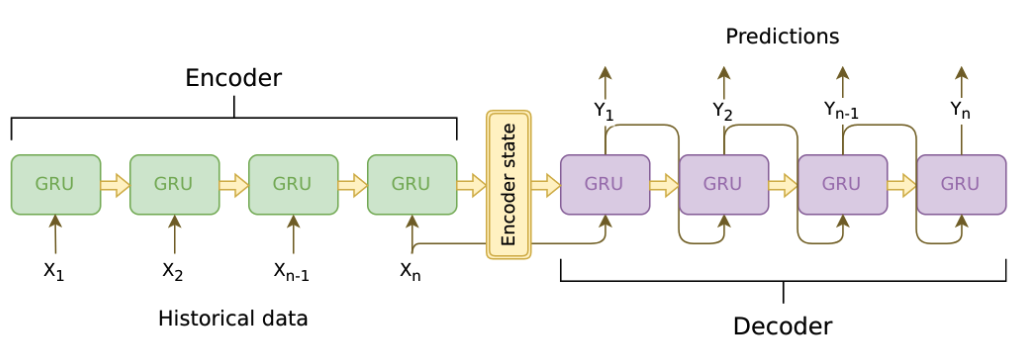

In [19]:
from IPython.display import Image
Image(filename="./figure/2.png", width=800, height=800)

## Encoder

EncoderÊòØ‰∏™RNNÔºåÂÆÉ‰ºöÈÅçÂéÜËæìÂÖ•ÁöÑÊØè‰∏Ä‰∏™Token(ËØç)ÔºåÊØè‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÊòØ‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÂíåËæìÂÖ•ÔºåÁÑ∂Âêé‰ºöÊúâ‰∏Ä‰∏™ËæìÂá∫ÂíåÊñ∞ÁöÑÈöêÁä∂ÊÄÅ„ÄÇËøô‰∏™Êñ∞ÁöÑÈöêÁä∂ÊÄÅ‰ºö‰Ωú‰∏∫‰∏ã‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÈöêÁä∂ÊÄÅ„ÄÇ

ÊØè‰∏™Êó∂ÂàªÈÉΩÊúâ‰∏Ä‰∏™ËæìÂá∫ÔºåÂØπ‰∫éseq2seqÊ®°ÂûãÊù•ËØ¥ÔºåÊàë‰ª¨ÈÄöÂ∏∏Âè™‰øùÁïôÊúÄÂêé‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåËÆ§‰∏∫ÂÆÉÁºñÁ†Å‰∫ÜÊï¥‰∏™Âè•Â≠êÁöÑËØ≠‰πâÔºå

‰ΩÜÊòØÂêéÈù¢Êàë‰ª¨‰ºöÁî®Âà∞AttentionÊú∫Âà∂ÔºåÂÆÉËøò‰ºöÁî®Âà∞EncoderÊØè‰∏™Êó∂ÂàªÁöÑËæìÂá∫„ÄÇEncoderÂ§ÑÁêÜÁªìÊùüÂêé‰ºöÊääÊúÄÂêé‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ‰Ωú‰∏∫DecoderÁöÑÂàùÂßãÈöêÁä∂ÊÄÅ„ÄÇ

Êàë‰ª¨‰ºö‰ΩøÁî®ÂèåÂêëÁöÑRNNÔºåÂ¶Ç‰∏ãÂõæÊâÄÁ§∫„ÄÇ

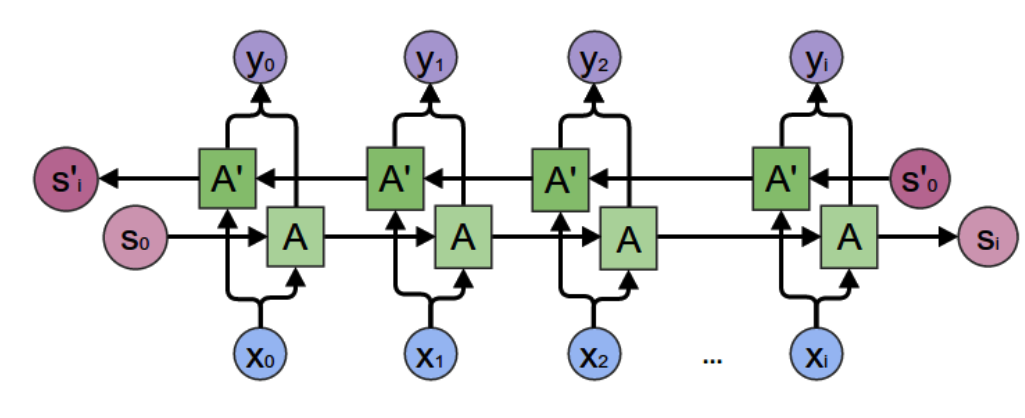

In [21]:
from IPython.display import Image
Image(filename="./figure/3.png", width=800, height=800)

Ê≥®ÊÑèÂú®Êé•ÂÖ•RNN‰πãÂâç‰ºöÊúâ‰∏Ä‰∏™embeddingÂ±ÇÔºåÁî®Êù•ÊääÊØè‰∏Ä‰∏™ËØç(IDÊàñËÄÖone-hotÂêëÈáè)Êò†Â∞ÑÊàê‰∏Ä‰∏™ËøûÁª≠ÁöÑÁ®†ÂØÜÁöÑÂêëÈáèÔºåÊàë‰ª¨ÂèØ‰ª•ËÆ§‰∏∫Ëøô‰∏™ÂêëÈáèÁºñÁ†Å‰∫Ü‰∏Ä‰∏™ËØçÁöÑËØ≠‰πâ„ÄÇÂú®Êàë‰ª¨ÁöÑÊ®°ÂûãÈáåÔºåÊàë‰ª¨ÊääÂÆÉÁöÑÂ§ßÂ∞èÂÆö‰πâÊàêÂíåRNNÁöÑÈöêÁä∂ÊÄÅÂ§ßÂ∞è‰∏ÄÊ†∑(‰ΩÜÊòØÂπ∂‰∏çÊòØ‰∏ÄÂÆöË¶Å‰∏ÄÊ†∑)„ÄÇÊúâ‰∫ÜEmbedding‰πãÂêéÔºåÊ®°Âûã‰ºöÊääÁõ∏‰ººÁöÑËØçÁºñÁ†ÅÊàêÁõ∏‰ººÁöÑÂêëÈáè(Ë∑ùÁ¶ªÊØîËæÉËøë)„ÄÇ

ÊúÄÂêéÔºå‰∏∫‰∫ÜÊääpaddingÁöÑbatchÊï∞ÊçÆ‰º†ÁªôRNNÔºåÊàë‰ª¨ÈúÄË¶Å‰ΩøÁî®‰∏ãÈù¢ÁöÑ‰∏§‰∏™ÂáΩÊï∞Êù•ËøõË°åpackÂíåunpackÔºåÂêéÈù¢Êàë‰ª¨‰ºöËØ¶ÁªÜ‰ªãÁªçÂÆÉ‰ª¨„ÄÇËøô‰∏§‰∏™ÂáΩÊï∞ÊòØÔºö
- torch.nn.utils.rnn.pack_padded_sequence
- torch.nn.utils.rnn.pad_packed_sequence

ËÆ°ÁÆóËøáÁ®ãÔºö
- 1) ÊääËØçÁöÑIDÈÄöËøáEmbeddingÂ±ÇÂèòÊàêÂêëÈáè„ÄÇ 
- 2) ÊääpaddingÂêéÁöÑÊï∞ÊçÆËøõË°åpack„ÄÇ 
- 3) ‰º†ÂÖ•GRUËøõË°åForwardËÆ°ÁÆó„ÄÇ 
- 4) UnpackËÆ°ÁÆóÁªìÊûú 
- 5) ÊääÂèåÂêëGRUÁöÑÁªìÊûúÂêëÈáèÂä†Ëµ∑Êù•„ÄÇ 
- 6) ËøîÂõû(ÊâÄÊúâÊó∂ÂàªÁöÑ)ËæìÂá∫ÂíåÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ„ÄÇ

ËæìÂÖ•:

- input_seq: ‰∏Ä‰∏™batchÁöÑËæìÂÖ•Âè•Â≠êÔºåshapeÊòØ(max_length, batch_size)
- input_lengths: ‰∏Ä‰∏™ÈïøÂ∫¶‰∏∫batchÁöÑlistÔºåË°®Á§∫Âè•Â≠êÁöÑÂÆûÈôÖÈïøÂ∫¶„ÄÇ
- hidden: ÂàùÂßãÂåñÈöêÁä∂ÊÄÅ(ÈÄöÂ∏∏ÊòØÈõ∂)ÔºåshapeÊòØ(n_layers x num_directions, batch_size, hidden_size)

ËæìÂá∫:

- outputs: ÊúÄÂêé‰∏ÄÂ±ÇGRUÁöÑËæìÂá∫ÂêëÈáè(ÂèåÂêëÁöÑÂêëÈáèÂä†Âú®‰∫Ü‰∏ÄËµ∑)Ôºåshape(max_length, batch_size, hidden_size)
- hidden: ÊúÄÂêé‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåshapeÊòØ(n_layers x num_directions, batch_size, hidden_size)

EncoderRNN‰ª£Á†ÅÂ¶Ç‰∏ãÔºö

In [22]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # ÂàùÂßãÂåñGRUÔºåËøôÈáåËæìÂÖ•ÂíåhiddenÂ§ßÂ∞èÈÉΩÊòØhidden_sizeÔºåËøôÈáåÂÅáËÆæembeddingÂ±ÇÁöÑËæìÂá∫Â§ßÂ∞èÊòØhidden_size
        # Â¶ÇÊûúÂè™Êúâ‰∏ÄÂ±ÇÔºåÈÇ£‰πà‰∏çËøõË°åDropoutÔºåÂê¶Âàô‰ΩøÁî®‰º†ÂÖ•ÁöÑÂèÇÊï∞dropoutËøõË°åGRUÁöÑDropout„ÄÇ
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # ËæìÂÖ•ÊòØ(max_length, batch)ÔºåEmbedding‰πãÂêéÂèòÊàê(max_length, batch, hidden_size)
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        # Âõ†‰∏∫RNN(GRU)Ë¶ÅÁü•ÈÅìÂÆûÈôÖÈïøÂ∫¶ÔºåÊâÄ‰ª•PyTorchÊèê‰æõ‰∫ÜÂáΩÊï∞pack_padded_sequenceÊääËæìÂÖ•ÂêëÈáèÂíåÈïøÂ∫¶
        # packÂà∞‰∏Ä‰∏™ÂØπË±°PackedSequenceÈáåÔºåËøôÊ†∑‰æø‰∫é‰ΩøÁî®„ÄÇ
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # ÈÄöËøáGRUËøõË°åforwardËÆ°ÁÆóÔºåÈúÄË¶Å‰º†ÂÖ•ËæìÂÖ•ÂíåÈöêÂèòÈáè
        # Â¶ÇÊûú‰º†ÂÖ•ÁöÑËæìÂÖ•ÊòØ‰∏Ä‰∏™Tensor (max_length, batch, hidden_size)
        # ÈÇ£‰πàËæìÂá∫outputsÊòØ(max_length, batch, hidden_size*num_directions)„ÄÇ
        # Á¨¨‰∏âÁª¥ÊòØhidden_sizeÂíånum_directionsÁöÑÊ∑∑ÂêàÔºåÂÆÉ‰ª¨ÂÆûÈôÖÊéíÂàóÈ°∫Â∫èÊòØnum_directionsÂú®ÂâçÈù¢Ôºå
        # Âõ†Ê≠§Êàë‰ª¨ÂèØ‰ª•‰ΩøÁî®outputs.view(seq_len, batch, num_directions, hidden_size)ÂæóÂà∞4Áª¥ÁöÑÂêëÈáè„ÄÇ
        # ÂÖ∂‰∏≠Á¨¨‰∏âÁª¥ÊòØÊñπÂêëÔºåÁ¨¨Âõõ‰ΩçÊòØÈöêÁä∂ÊÄÅ„ÄÇ
        
        # ËÄåÂ¶ÇÊûúËæìÂÖ•ÊòØPackedSequenceÂØπË±°ÔºåÈÇ£‰πàËæìÂá∫outputs‰πüÊòØ‰∏Ä‰∏™PackedSequenceÂØπË±°ÔºåÊàë‰ª¨ÈúÄË¶ÅÁî®
        # ÂáΩÊï∞pad_packed_sequenceÊääÂÆÉÂèòÊàêshape‰∏∫(max_length, batch, hidden*num_directions)ÁöÑÂêëÈáè‰ª•Âèä
        # ‰∏Ä‰∏™listÔºåË°®Á§∫ËæìÂá∫ÁöÑÈïøÂ∫¶ÔºåÂΩìÁÑ∂Ëøô‰∏™listÂíåËæìÂÖ•ÁöÑinput_lengthsÂÆåÂÖ®‰∏ÄÊ†∑ÔºåÂõ†Ê≠§ÈÄöÂ∏∏Êàë‰ª¨‰∏çÈúÄË¶ÅÂÆÉ„ÄÇ
        outputs, hidden = self.gru(packed, hidden)
        # ÂèÇËÄÉÂâçÈù¢ÁöÑÊ≥®ÈáäÔºåÊàë‰ª¨ÂæóÂà∞outputs‰∏∫(max_length, batch, hidden*num_directions)
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Êàë‰ª¨ÈúÄË¶ÅÊääËæìÂá∫ÁöÑnum_directionsÂèåÂêëÁöÑÂêëÈáèÂä†Ëµ∑Êù•
        # Âõ†‰∏∫outputsÁöÑÁ¨¨‰∏âÁª¥ÊòØÂÖàÊîæÂâçÂêëÁöÑhidden_size‰∏™ÁªìÊûúÔºåÁÑ∂ÂêéÂÜçÊîæÂêéÂêëÁöÑhidden_size‰∏™ÁªìÊûú
        # ÊâÄ‰ª•outputs[:, :, :self.hidden_size]ÂæóÂà∞ÂâçÂêëÁöÑÁªìÊûú
        # outputs[:, :, self.hidden_size:]ÊòØÂêéÂêëÁöÑÁªìÊûú
        # Ê≥®ÊÑèÔºåÂ¶ÇÊûúbidirectionalÊòØFalseÔºåÂàôoutputsÁ¨¨‰∏âÁª¥ÁöÑÂ§ßÂ∞èÂ∞±ÊòØhidden_sizeÔºå
        # ËøôÊó∂outputs[:, : ,self.hidden_size:]ÊòØ‰∏çÂ≠òÂú®ÁöÑÔºåÂõ†Ê≠§‰πü‰∏ç‰ºöÂä†‰∏äÂéª„ÄÇ
        # ÂØπPython slicing‰∏çÁÜüÁöÑËØªËÄÖÂèØ‰ª•ÁúãÁúã‰∏ãÈù¢ÁöÑ‰æãÂ≠êÔºö
        
        # >>> a=[1,2,3]
        # >>> a[:3]
        # [1, 2, 3]
        # >>> a[3:]
        # []
        # >>> a[:3]+a[3:]
        # [1, 2, 3]
        
        # ËøôÊ†∑Â∞±‰∏çÁî®ÂÜô‰∏ãÈù¢ÁöÑ‰ª£Á†Å‰∫ÜÔºö
        # if bidirectional:
        #     outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # ËøîÂõûÊúÄÁªàÁöÑËæìÂá∫ÂíåÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ„ÄÇ 
        return outputs, hidden

## Decoder

Decoder‰πüÊòØ‰∏Ä‰∏™RNNÔºåÂÆÉÊØè‰∏™Êó∂ÂàªËæìÂá∫‰∏Ä‰∏™ËØç„ÄÇÊØè‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÊòØ‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÂíå‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫„ÄÇ

‰∏ÄÂºÄÂßãÁöÑÈöêÁä∂ÊÄÅÊòØEncoderÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåËæìÂÖ•ÊòØÁâπÊÆäÁöÑ„ÄÇÁÑ∂Âêé‰ΩøÁî®RNNËÆ°ÁÆóÊñ∞ÁöÑÈöêÁä∂ÊÄÅÂíåËæìÂá∫Á¨¨‰∏Ä‰∏™ËØçÔºåÊé•ÁùÄÁî®Êñ∞ÁöÑÈöêÁä∂ÊÄÅÂíåÁ¨¨‰∏Ä‰∏™ËØçËÆ°ÁÆóÁ¨¨‰∫å‰∏™ËØçÔºå...ÔºåÁõ¥Âà∞ÈÅáÂà∞ÔºåÁªìÊùüËæìÂá∫„ÄÇ

ÊôÆÈÄöÁöÑRNN DecoderÁöÑÈóÆÈ¢òÊòØÂÆÉÂè™‰æùËµñ‰∏éEncoderÊúÄÂêé‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåËôΩÁÑ∂ÁêÜËÆ∫‰∏äËøô‰∏™ÈöêÁä∂ÊÄÅ(contextÂêëÈáè)ÂèØ‰ª•ÁºñÁ†ÅËæìÂÖ•Âè•Â≠êÁöÑËØ≠‰πâÔºå‰ΩÜÊòØÂÆûÈôÖ‰ºöÊØîËæÉÂõ∞Èöæ„ÄÇÂõ†Ê≠§ÂΩìËæìÂÖ•Âè•Â≠êÂæàÈïøÁöÑÊó∂ÂÄôÔºåÊïàÊûú‰ºöÂæàÂ∑Æ„ÄÇ

‰∏∫‰∫ÜËß£ÂÜ≥Ëøô‰∏™ÈóÆÈ¢òÔºåBahdanauÁ≠â‰∫∫Âú®ËÆ∫ÊñáÈáåÊèêÂá∫‰∫ÜÊ≥®ÊÑèÂäõÊú∫Âà∂(attention mechanism)ÔºåÂú®DecoderËøõË°åtÊó∂ÂàªËÆ°ÁÆóÁöÑÊó∂ÂÄôÔºåÈô§‰∫Üt-1Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåÂΩìÂâçÊó∂ÂàªÁöÑËæìÂÖ•Ôºå**Ê≥®ÊÑèÂäõÊú∫Âà∂ËøòÂèØ‰ª•ÂèÇËÄÉEncoderÊâÄÊúâÊó∂ÂàªÁöÑËæìÂÖ•„ÄÇ**

ÊãøÊú∫Âô®ÁøªËØëÊù•ËØ¥ÔºåÊàë‰ª¨Âú®ÁøªËØë‰ª•Âè•Â≠êÁöÑÁ¨¨t‰∏™ËØçÁöÑÊó∂ÂÄô‰ºöÊääÊ≥®ÊÑèÂäõÊú∫Âà∂Âú®Êüê‰∏™ËØç‰∏ä„ÄÇÂΩìÁÑ∂Â∏∏ËßÅÁöÑÊ≥®ÊÑèÂäõÊòØ‰∏ÄÁßçsoftÁöÑÊ≥®ÊÑèÂäõÔºåÂÅáËÆæËæìÂÖ•Êúâ5‰∏™ËØçÔºåÊ≥®ÊÑèÂäõÂèØËÉΩÊòØ‰∏Ä‰∏™Ê¶ÇÁéáÔºåÊØîÂ¶Ç(0.6,0.1,0.1,0.1,0.1)ÔºåË°®Á§∫ÂΩìÂâçÊúÄÂÖ≥Ê≥®ÁöÑÊòØËæìÂÖ•ÁöÑÁ¨¨‰∏Ä‰∏™ËØç„ÄÇÂêåÊó∂Êàë‰ª¨‰πãÂâç‰πüËÆ°ÁÆóÂá∫ÊØè‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÂêëÈáèÔºåÂÅáËÆæ5‰∏™Êó∂ÂàªÂàÜÂà´ÊòØùë¶1,‚Ä¶,ùë¶5ÔºåÈÇ£‰πàÊàë‰ª¨ÂèØ‰ª•Áî®attentionÊ¶ÇÁéáÂä†ÊùÉÂæóÂà∞ÂΩìÂâçÊó∂ÂàªÁöÑcontextÂêëÈáè0.6ùë¶1+0.1ùë¶2+‚Ä¶+0.1ùë¶5„ÄÇ

Ê≥®ÊÑèÂäõÊúâÂæàÂ§öÊñπÊ≥ïËÆ°ÁÆóÔºåÊàë‰ª¨ËøôÈáå‰ªãÁªçLuongÁ≠â‰∫∫Âú®ËÆ∫ÊñáÊèêÂá∫ÁöÑÊñπÊ≥ï„ÄÇÂÆÉÊòØÁî®ÂΩìÂâçÊó∂ÂàªÁöÑGRUËÆ°ÁÆóÂá∫ÁöÑÊñ∞ÁöÑÈöêÁä∂ÊÄÅÊù•ËÆ°ÁÆóÊ≥®ÊÑèÂäõÂæóÂàÜÔºåÈ¶ñÂÖàÂÆÉÁî®‰∏Ä‰∏™scoreÂáΩÊï∞ËÆ°ÁÆóËøô‰∏™ÈöêÁä∂ÊÄÅÂíåEncoderÁöÑËæìÂá∫ÁöÑÁõ∏‰ººÂ∫¶ÂæóÂàÜÔºåÂæóÂàÜË∂äÂ§ßÔºåËØ¥ÊòéË∂äÂ∫îËØ•Ê≥®ÊÑèËøô‰∏™ËØç„ÄÇÁÑ∂ÂêéÂÜçÁî®softmaxÂáΩÊï∞ÊääscoreÂèòÊàêÊ¶ÇÁéá„ÄÇÈÇ£Êú∫Âô®ÁøªËØë‰∏∫‰æãÔºåÂú®tÊó∂ÂàªÔºå‚Ñéùë°Ë°®Á§∫tÊó∂ÂàªÁöÑGRUËæìÂá∫ÁöÑÊñ∞ÁöÑÈöêÁä∂ÊÄÅÔºåÊàë‰ª¨ÂèØ‰ª•ËÆ§‰∏∫‚Ñéùë°Ë°®Á§∫ÂΩìÂâçÈúÄË¶ÅÁøªËØëÁöÑËØ≠‰πâ„ÄÇÈÄöËøáËÆ°ÁÆó‚Ñéùë°‰∏éùë¶1,‚Ä¶,ùë¶ùëõÁöÑÂæóÂàÜÔºåÂ¶ÇÊûú‚Ñéùë°‰∏éùë¶1ÁöÑÂæóÂàÜÂæàÈ´òÔºåÈÇ£‰πàÊàë‰ª¨ÂèØ‰ª•ËÆ§‰∏∫ÂΩìÂâç‰∏ªË¶ÅÁøªËØëËØçùë•1ÁöÑËØ≠‰πâ„ÄÇÊúâÂæàÂ§ö‰∏≠scoreÂáΩÊï∞ÁöÑËÆ°ÁÆóÊñπÊ≥ïÔºåÂ¶Ç‰∏ãÂõæÊâÄÁ§∫Ôºö

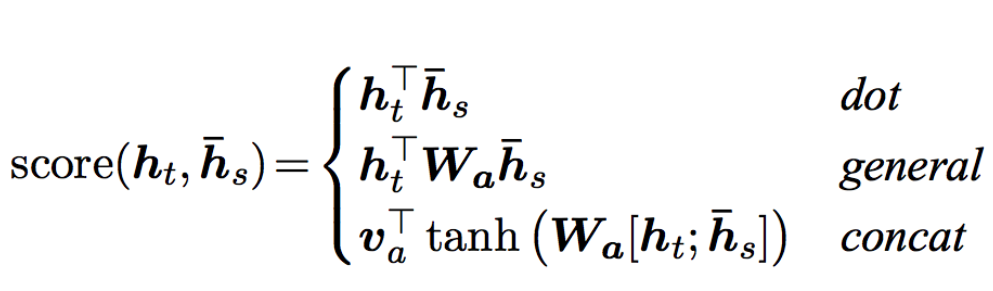

In [23]:
from IPython.display import Image
Image(filename="./figure/4.png", width=800, height=800)

‰∏äÂºè‰∏≠‚Ñéùë°Ë°®Á§∫tÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºåÊØîÂ¶ÇÁ¨¨‰∏ÄÁßçËÆ°ÁÆóscoreÁöÑÊñπÊ≥ïÔºåÁõ¥Êé•ËÆ°ÁÆó‚Ñéùë°‰∏é‚Ñéùë†ÁöÑÂÜÖÁßØÔºåÂÜÖÁßØË∂äÂ§ßÔºåËØ¥ÊòéËøô‰∏§‰∏™ÂêëÈáèË∂äÁõ∏‰ººÔºåÂõ†Ê≠§Ê≥®ÊÑèÂäõ‰πüÊõ¥Â§öÁöÑÊîæÂà∞Ëøô‰∏™ËØç‰∏ä„ÄÇÁ¨¨‰∫åÁßçÊñπÊ≥ï‰πüÁ±ª‰ººÔºåÂè™ÊòØÂºïÂÖ•‰∫Ü‰∏Ä‰∏™ÂèØ‰ª•Â≠¶‰π†ÁöÑÁü©ÈòµÔºåÊàë‰ª¨ÂèØ‰ª•ËÆ§‰∏∫ÂÆÉÂÖàÂØπ‚Ñéùë°ÂÅö‰∏Ä‰∏™Á∫øÊÄßÂèòÊç¢ÔºåÁÑ∂ÂêéÂú®‰∏é‚Ñéùë†ËÆ°ÁÆóÂÜÖÁßØ„ÄÇËÄåÁ¨¨‰∏âÁßçÊñπÊ≥ïÊääÂÆÉ‰ª¨ÊãºÊé•Ëµ∑Êù•ÁÑ∂ÂêéÁî®‰∏Ä‰∏™ÂÖ®ËøûÊé•ÁΩëÁªúÊù•ËÆ°ÁÆóscore„ÄÇ

Ê≥®ÊÑèÔºåÊàë‰ª¨ÂâçÈù¢‰ªãÁªçÁöÑÊòØÂàÜÂà´ËÆ°ÁÆó‚Ñéùë°Âíåùë¶1ÁöÑÂÜÖÁßØ„ÄÅ‚Ñéùë°Âíåùë¶2ÁöÑÂÜÖÁßØÔºå‚Ä¶„ÄÇ‰ΩÜÊòØ‰∏∫‰∫ÜÊïàÁéáÔºåÂèØ‰ª•‰∏ÄÊ¨°ËÆ°ÁÆó‚Ñéùë°‰∏é‚Ñéùë†=[ùë¶1,ùë¶2,‚Ä¶,ùë¶ùëõ]ÁöÑ‰πòÁßØ„ÄÇ „ÄÇ



In [24]:
# Luong Ê≥®ÊÑèÂäõlayer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = torch.nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        # ËæìÂÖ•hiddenÁöÑshapeÊòØ(1, batch=64, hidden_size=500)
        # encoder_outputsÁöÑshapeÊòØ(input_lengths=10, batch=64, hidden_size=500)
        # hidden * encoder_outputÂæóÂà∞ÁöÑshapeÊòØ(10, 64, 500)ÔºåÁÑ∂ÂêéÂØπÁ¨¨3Áª¥Ê±ÇÂíåÂ∞±ÂèØ‰ª•ËÆ°ÁÆóÂá∫score„ÄÇ
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), 
				      encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)
    
    # ËæìÂÖ•ÊòØ‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅhiddenÂíåÊâÄÊúâÊó∂ÂàªÁöÑEncoderÁöÑËæìÂá∫encoder_outputs
    # ËæìÂá∫ÊòØÊ≥®ÊÑèÂäõÁöÑÊ¶ÇÁéáÔºå‰πüÂ∞±ÊòØÈïøÂ∫¶‰∏∫input_lengthsÁöÑÂêëÈáèÔºåÂÆÉÁöÑÂíåÂä†Ëµ∑Êù•ÊòØ1„ÄÇ
    def forward(self, hidden, encoder_outputs):
        # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÁöÑscoreÔºåËæìÂÖ•hiddenÁöÑshapeÊòØ(1, batch=64, hidden_size=500)Ôºå
        # Ë°®Á§∫tÊó∂ÂàªbatchÊï∞ÊçÆÁöÑÈöêÁä∂ÊÄÅ
        # encoder_outputsÁöÑshapeÊòØ(input_lengths=10, batch=64, hidden_size=500) 
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            # ËÆ°ÁÆóÂÜÖÁßØÔºåÂèÇËÄÉdot_scoreÂáΩÊï∞
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        # Êääattn_energies‰ªé(max_length=10, batch=64)ËΩ¨ÁΩÆÊàê(64, 10)
        attn_energies = attn_energies.t()

        # ‰ΩøÁî®softmaxÂáΩÊï∞ÊääscoreÂèòÊàêÊ¶ÇÁéáÔºåshape‰ªçÁÑ∂ÊòØ(64, 10)ÔºåÁÑ∂ÂêéÁî®unsqueeze(1)ÂèòÊàê
        # (64, 1, 10) 
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

‰∏äÈù¢ÁöÑ‰ª£Á†ÅÂÆûÁé∞‰∫Üdot„ÄÅgeneralÂíåconcat‰∏âÁßçscoreËÆ°ÁÆóÊñπÊ≥ïÔºåÂàÜÂà´ÂíåÂâçÈù¢ÁöÑ‰∏â‰∏™ÂÖ¨ÂºèÂØπÂ∫î

Êúâ‰∫ÜÊ≥®ÊÑèÂäõÁöÑÂ≠êÊ®°Âùó‰πãÂêéÔºåÊàë‰ª¨Â∞±ÂèØ‰ª•ÂÆûÁé∞Decoder‰∫Ü„ÄÇEncoderÂèØ‰ª•‰∏ÄÊ¨°Êää‰∏Ä‰∏™Â∫èÂàóËæìÂÖ•GRUÔºåÂæóÂà∞Êï¥‰∏™Â∫èÂàóÁöÑËæìÂá∫„ÄÇ‰ΩÜÊòØDecoder tÊó∂ÂàªÁöÑËæìÂÖ•ÊòØt-1Êó∂ÂàªÁöÑËæìÂá∫ÔºåÂú®t-1Êó∂ÂàªËÆ°ÁÆóÂÆåÊàê‰πãÂâçÊòØÊú™Áü•ÁöÑÔºåÂõ†Ê≠§Âè™ËÉΩ‰∏ÄÊ¨°Â§ÑÁêÜ‰∏Ä‰∏™Êó∂ÂàªÁöÑÊï∞ÊçÆ„ÄÇ

Âõ†Ê≠§EncoderÁöÑGRUÁöÑËæìÂÖ•ÊòØ(max_length, batch, hidden_size)ÔºåËÄåDecoderÁöÑËæìÂÖ•ÊòØ(1, batch, hidden_size)„ÄÇ

Ê≠§Â§ñDecoderÂè™ËÉΩÂà©Áî®ÂâçÈù¢ÁöÑ‰ø°ÊÅØÔºåÊâÄ‰ª•Âè™ËÉΩ‰ΩøÁî®ÂçïÂêë(ËÄå‰∏çÊòØÂèåÂêë)ÁöÑGRUÔºåËÄåEncoderÁöÑGRUÊòØÂèåÂêëÁöÑÔºåÂ¶ÇÊûú‰∏§ÁßçÁöÑhidden_sizeÊòØ‰∏ÄÊ†∑ÁöÑÔºåÂàôDecoderÁöÑÈöêÂçïÂÖÉ‰∏™Êï∞Â∞ë‰∫Ü‰∏ÄÂçäÔºåÈÇ£ÊÄé‰πàÊääEncoderÁöÑÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ‰Ωú‰∏∫DecoderÁöÑÂàùÂßãÈöêÁä∂ÊÄÅÂë¢Ôºü

ËøôÈáåÊòØÊääÊØè‰∏™Êó∂ÂàªÂèåÂêëÁªìÊûúÂä†Ëµ∑Êù•ÁöÑÔºåÂõ†Ê≠§ÂÆÉ‰ª¨ÁöÑÂ§ßÂ∞èÂ∞±ËÉΩÂåπÈÖç‰∫ÜÔºàËØ∑ËØªËÄÖÂèÇËÄÉÂâçÈù¢EncoderÂèåÂêëÁõ∏Âä†ÁöÑÈÉ®ÂàÜ‰ª£Á†ÅÔºâ„ÄÇ

ËÆ°ÁÆóÂõæÔºö
- 1) ÊääËØçIDËæìÂÖ•EmbeddingÂ±Ç 
- 2) ‰ΩøÁî®ÂçïÂêëÁöÑGRUÁªßÁª≠ForwardËøõË°å‰∏Ä‰∏™Êó∂ÂàªÁöÑËÆ°ÁÆó„ÄÇ 
- 3) ‰ΩøÁî®Êñ∞ÁöÑÈöêÁä∂ÊÄÅËÆ°ÁÆóÊ≥®ÊÑèÂäõÊùÉÈáç 
- 4) Áî®Ê≥®ÊÑèÂäõÊùÉÈáçÂæóÂà∞contextÂêëÈáè 
- 5) contextÂêëÈáèÂíåGRUÁöÑËæìÂá∫ÊãºÊé•Ëµ∑Êù•ÔºåÁÑ∂ÂêéÂÜçÁªèËøá‰∏Ä‰∏™ÂÖ®ËøûÊé•ÁΩëÁªúÔºå‰ΩøÂæóËæìÂá∫Â§ßÂ∞è‰ªçÁÑ∂ÊòØhidden_size 
- 6) ‰ΩøÁî®‰∏Ä‰∏™ÊäïÂΩ±Áü©ÈòµÊääËæìÂá∫‰ªéhidden_sizeÂèòÊàêËØçÂÖ∏Â§ßÂ∞èÔºåÁÑ∂ÂêéÁî®softmaxÂèòÊàêÊ¶ÇÁéá 
- 7) ËøîÂõûËæìÂá∫ÂíåÊñ∞ÁöÑÈöêÁä∂ÊÄÅ



ËæìÂÖ•Ôºö
- input_step: shapeÊòØ(1, batch_size)
- last_hidden: ‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅÔºå shapeÊòØ(n_layers x num_directions, batch_size, hidden_size)
- encoder_outputs: encoderÁöÑËæìÂá∫Ôºå shapeÊòØ(max_length, batch_size, hidden_size)

In [25]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # ‰øùÂ≠òÂà∞selfÈáåÔºåattn_modelÂ∞±ÊòØÂâçÈù¢ÂÆö‰πâÁöÑAttnÁ±ªÁöÑÂØπË±°„ÄÇ
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # ÂÆö‰πâDecoderÁöÑlayers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Ê≥®ÊÑèÔºödecoderÊØè‰∏ÄÊ≠•Âè™ËÉΩÂ§ÑÁêÜ‰∏Ä‰∏™Êó∂ÂàªÁöÑÊï∞ÊçÆÔºåÂõ†‰∏∫tÊó∂ÂàªËÆ°ÁÆóÂÆå‰∫ÜÊâçËÉΩËÆ°ÁÆót+1Êó∂Âàª„ÄÇ
        # input_stepÁöÑshapeÊòØ(1, 64)Ôºå64ÊòØbatchÔºå1ÊòØÂΩìÂâçËæìÂÖ•ÁöÑËØçID(Êù•Ëá™‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫)
        # ÈÄöËøáembeddingÂ±ÇÂèòÊàê(1, 64, 500)ÔºåÁÑ∂ÂêéËøõË°ådropoutÔºåshape‰∏çÂèò„ÄÇ
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Êääembedded‰º†ÂÖ•GRUËøõË°åforwardËÆ°ÁÆó
        # ÂæóÂà∞rnn_outputÁöÑshapeÊòØ(1, 64, 500)
        # hiddenÊòØ(2, 64, 500)ÔºåÂõ†‰∏∫ÊòØ‰∏§Â±ÇÁöÑGRUÔºåÊâÄ‰ª•Á¨¨‰∏ÄÁª¥ÊòØ2„ÄÇ
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÊùÉÈáçÔºå Ê†πÊçÆÂâçÈù¢ÁöÑÂàÜÊûêÔºåattn_weightsÁöÑshapeÊòØ(64, 1, 10)
        attn_weights = self.attn(rnn_output, encoder_outputs)
        
        # encoder_outputsÊòØ(10, 64, 500) 
        # encoder_outputs.transpose(0, 1)ÂêéÁöÑshapeÊòØ(64, 10, 500)
        # attn_weights.bmmÂêéÊòØ(64, 1, 500)
        
        # bmmÊòØÊâπÈáèÁöÑÁü©Èòµ‰πòÊ≥ïÔºåÁ¨¨‰∏ÄÁª¥ÊòØbatchÔºåÊàë‰ª¨ÂèØ‰ª•Êääattn_weightsÁúãÊàê64‰∏™(1,10)ÁöÑÁü©Èòµ
        # Êääencoder_outputs.transpose(0, 1)ÁúãÊàê64‰∏™(10, 500)ÁöÑÁü©Èòµ
        # ÈÇ£‰πàbmmÂ∞±ÊòØ64‰∏™(1, 10)Áü©Èòµ x (10, 500)Áü©ÈòµÔºåÊúÄÁªàÂæóÂà∞(64, 1, 500)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # ÊääcontextÂêëÈáèÂíåGRUÁöÑËæìÂá∫ÊãºÊé•Ëµ∑Êù•
        # rnn_output‰ªé(1, 64, 500)ÂèòÊàê(64, 500)
        rnn_output = rnn_output.squeeze(0)
        # context‰ªé(64, 1, 500)ÂèòÊàê(64, 500)
        context = context.squeeze(1)
        # ÊãºÊé•ÂæóÂà∞(64, 1000)
        concat_input = torch.cat((rnn_output, context), 1)
        # self.concatÊòØ‰∏Ä‰∏™Áü©Èòµ(1000, 500)Ôºå
        # self.concat(concat_input)ÁöÑËæìÂá∫ÊòØ(64, 500)
        # ÁÑ∂ÂêéÁî®tanhÊääËæìÂá∫ËøîÂõûÂèòÊàê(-1,1)Ôºåconcat_outputÁöÑshapeÊòØ(64, 500)
        concat_output = torch.tanh(self.concat(concat_input))

        # outÊòØ(500, ËØçÂÖ∏Â§ßÂ∞è=7826)    
        output = self.out(concat_output)
        # Áî®softmaxÂèòÊàêÊ¶ÇÁéáÔºåË°®Á§∫ÂΩìÂâçÊó∂ÂàªËæìÂá∫ÊØè‰∏™ËØçÁöÑÊ¶ÇÁéá„ÄÇ
        output = F.softmax(output, dim=1)
        # ËøîÂõû outputÂíåÊñ∞ÁöÑÈöêÁä∂ÊÄÅ 
        return output, hidden

##  ÂÆö‰πâËÆ≠ÁªÉËøáÁ®ã

## Masked ÊçüÂ§±

forwardÂÆûÁé∞‰πãÂêéÔºåÊàë‰ª¨Â∞±ÈúÄË¶ÅËÆ°ÁÆóloss„ÄÇseq2seqÊúâ‰∏§‰∏™RNNÔºåEncoder RNNÊòØÊ≤°ÊúâÁõ¥Êé•ÂÆö‰πâÊçüÂ§±ÂáΩÊï∞ÁöÑÔºåÂÆÉÊòØÈÄöËøáÂΩ±ÂìçDecoder‰ªéËÄåÂΩ±ÂìçÊúÄÁªàÁöÑËæìÂá∫‰ª•Âèäloss„ÄÇ

DecoderËæìÂá∫‰∏Ä‰∏™Â∫èÂàóÔºåÂâçÈù¢Êàë‰ª¨‰ªãÁªçÁöÑÊòØDecoderÂú®È¢ÑÊµãÊó∂ÁöÑËøáÁ®ãÔºåÂÆÉÁöÑÈïøÂ∫¶ÊòØ‰∏çÂõ∫ÂÆöÁöÑÔºåÂè™ÊúâÈÅáÂà∞EOSÊâçÁªìÊùü„ÄÇÁªôÂÆö‰∏Ä‰∏™ÈóÆÁ≠îÂè•ÂØπÔºåÊàë‰ª¨ÂèØ‰ª•ÊääÈóÆÈ¢òËæìÂÖ•EncoderÔºåÁÑ∂ÂêéÁî®DecoderÂæóÂà∞‰∏Ä‰∏™ËæìÂá∫Â∫èÂàóÔºå‰ΩÜÊòØËøô‰∏™ËæìÂá∫Â∫èÂàóÂíå‚ÄùÁúüÂÆû‚ÄùÁöÑÁ≠îÊ°àÈïøÂ∫¶Âπ∂‰∏çÁõ∏Âêå„ÄÇ

ËÄå‰∏îÂç≥‰ΩøÈïøÂ∫¶Áõ∏ÂêåÂπ∂‰∏îËØ≠‰πâÁõ∏‰ººÔºå‰πüÂæàÈöæÁõ¥Êé•Áü•ÈÅìÈ¢ÑÊµãÁöÑÁ≠îÊ°àÂíåÁúüÂÆûÁöÑÁ≠îÊ°àÊòØÂê¶Á±ª‰ºº„ÄÇ

ÈÇ£‰πàÊàë‰ª¨ÊÄé‰πàËÆ°ÁÆólossÂë¢ÔºüÊØîÂ¶ÇËæìÂÖ•ÊòØ‚ÄùWhat is your name?‚ÄùÔºåËÆ≠ÁªÉÊï∞ÊçÆ‰∏≠ÁöÑÁ≠îÊ°àÊòØ‚ÄùI am LiLi‚Äù„ÄÇ

ÂÅáËÆæÊ®°ÂûãÊúâ‰∏§ÁßçÈ¢ÑÊµãÔºö‚ÄùI am fine‚ÄùÂíå‚ÄùMy name is LiLi‚Äù„ÄÇ‰ªéËØ≠‰πâ‰∏äÊòæÁÑ∂Á¨¨‰∫åÁßçÁ≠îÊ°àÊõ¥Â•ΩÔºå‰ΩÜÊòØÂ¶ÇÊûúÂ≠óÈù¢‰∏äÊØîËæÉÁöÑËØùÂèØËÉΩÁ¨¨‰∏ÄÁßçÊõ¥Â•Ω„ÄÇ

‰ΩÜÊòØËÆ©Êú∫Âô®Áü•ÈÅì‚ÄùI am LiLi‚ÄùÂíå‚ÄùMy name is LiLi‚ÄùÁöÑËØ≠‰πâÂæàÊé•ËøëËøôÊòØÈùûÂ∏∏Âõ∞ÈöæÁöÑÔºåÊâÄ‰ª•ÂÆûÈôÖ‰∏äÊàë‰ª¨ÈÄöÂ∏∏ËøòÊòØÈÄöËøáÂ≠óÈù¢‰∏äÈáåËøõË°åÊØîËæÉ„ÄÇ

Êàë‰ª¨‰ºöÈôêÂà∂DecoderÁöÑËæìÂá∫Ôºå‰ΩøÂæóDecoderÁöÑËæìÂá∫ÈïøÂ∫¶Âíå‚ÄùÁúüÂÆû‚ÄùÁ≠îÊ°à‰∏ÄÊ†∑ÔºåÁÑ∂ÂêéÈÄê‰∏™Êó∂ÂàªÊØîËæÉ„ÄÇ

DecoderËæìÂá∫ÁöÑÊòØÊØè‰∏™ËØçÁöÑÊ¶ÇÁéáÂàÜÂ∏ÉÔºåÂõ†Ê≠§ÂèØ‰ª•‰ΩøÁî®‰∫§ÂèâÁÜµÊçüÂ§±ÂáΩÊï∞„ÄÇ‰ΩÜÊòØËøôÈáåËøòÊúâ‰∏Ä‰∏™ÈóÆÈ¢òÔºå
Âõ†‰∏∫ÊòØ‰∏Ä‰∏™batchÁöÑÊï∞ÊçÆÈáåÊúâ‰∏Ä‰∫õÊòØpaddingÁöÑÔºåÂõ†Ê≠§Ëøô‰∫õ‰ΩçÁΩÆÁöÑÈ¢ÑÊµãÊòØÊ≤°ÊúâÂøÖË¶ÅËÆ°ÁÆólossÁöÑÔºå
Âõ†Ê≠§Êàë‰ª¨ÈúÄË¶Å‰ΩøÁî®ÂâçÈù¢ÁöÑmaskÁü©ÈòµÊääÂØπÂ∫î‰ΩçÁΩÆÁöÑlossÂéªÊéâÔºåÊàë‰ª¨ÂèØ‰ª•ÈÄöËøá‰∏ãÈù¢ÁöÑÂáΩÊï∞Êù•ÂÆûÁé∞ËÆ°ÁÆóMaskedÁöÑloss„ÄÇ

In [26]:
def maskNLLLoss(inp, target, mask):
    # ËÆ°ÁÆóÂÆûÈôÖÁöÑËØçÁöÑ‰∏™Êï∞ÔºåÂõ†‰∏∫paddingÊòØ0ÔºåÈùûpaddingÊòØ1ÔºåÂõ†Ê≠§sumÂ∞±ÂèØ‰ª•ÂæóÂà∞ËØçÁöÑ‰∏™Êï∞
    nTotal = mask.sum()
    
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

‰∏äÈù¢ÁöÑ‰ª£Á†ÅÊúâÂá†‰∏™ÈúÄË¶ÅÊ≥®ÊÑèÁöÑÂú∞Êñπ„ÄÇÈ¶ñÂÖàÊòØmasked_selectÂáΩÊï∞ÔºåÊàë‰ª¨Êù•Áúã‰∏Ä‰∏™‰æãÂ≠êÔºö



In [27]:
x = torch.randn(3, 4)
print("x:",x)
mask = x.ge(0.5)
print("mask:",mask)
res = torch.masked_select(x, mask)
print("res:",res)

x: tensor([[ 0.3252,  1.4716,  0.0217, -0.4123],
        [ 1.7617,  1.2460, -0.2314,  1.7477],
        [ 1.4859,  1.0349,  1.4949,  1.6096]])
mask: tensor([[False,  True, False, False],
        [ True,  True, False,  True],
        [ True,  True,  True,  True]])
res: tensor([1.4716, 1.7617, 1.2460, 1.7477, 1.4859, 1.0349, 1.4949, 1.6096])


ÂÆÉË¶ÅÊ±ÇmaskÂíåË¢´maskÁöÑtensorÁöÑshapeÊòØ‰∏ÄÊ†∑ÁöÑÔºåÁÑ∂Âêé‰ªécrossEntropyÈÄâÂá∫maskÂÄº‰∏∫1ÁöÑÈÇ£‰∫õÂÄº„ÄÇËæìÂá∫ÁöÑÁª¥Â∫¶‰ºöÂáè1„ÄÇ

**Âè¶Â§ñ‰∏∫‰∫ÜÂÆûÁé∞‰∫§ÂèâÁÜµËøôÈáå‰ΩøÁî®‰∫ÜgatherÂáΩÊï∞ÔºåËøôÊòØ‰∏ÄÁßçÊØîËæÉÂ∫ïÂ±ÇÁöÑÂÆûÁé∞ÊñπÊ≥ïÔºåÊõ¥ÁÆÄ‰æøÁöÑÊñπÊ≥ïÂ∫îËØ•‰ΩøÁî®CrossEntropyLossÊàñËÄÖNLLLossÔºåÂÖ∂‰∏≠CrossEntropyÁ≠â‰ª∑‰∏éLogSoftmax+NLLLoss„ÄÇ**

‰∫§ÂèâÁÜµÁöÑÂÆö‰πâ‰∏∫Ôºöùêª(ùëù,ùëû)=‚àí‚àëùë•ùëù(ùë•)ùëôùëúùëîùëû(ùë•)„ÄÇ

**ÂÖ∂‰∏≠pÂíåqÊòØ‰∏§‰∏™ÈöèÊú∫ÂèòÈáèÁöÑÊ¶ÇÁéáÂàÜÂ∏ÉÔºåËøôÈáåÊòØÁ¶ªÊï£ÁöÑÈöèÊú∫ÂèòÈáèÔºåÂ¶ÇÊûúÊòØËøûÁª≠ÁöÑÈúÄË¶ÅÊääÊ±ÇÂíåÂèòÊàêÁßØÂàÜ„ÄÇÂú®Êàë‰ª¨ËøôÈáåpÊòØÁúüÂÆûÁöÑÂàÜÂ∏ÉÔºå‰πüÂ∞±ÊòØone-hotÁöÑÔºåËÄåqÊòØÊ®°ÂûãÈ¢ÑÊµãÁöÑsoftmaxÁöÑËæìÂá∫„ÄÇÂõ†‰∏∫pÊòØone-hotÁöÑÔºåÊâÄ‰ª•Âè™ÈúÄË¶ÅËÆ°ÁÆóÁúüÂÆûÂàÜÁ±ªÂØπÂ∫îÁöÑÈÇ£‰∏™ÂÄº„ÄÇ**

ÊØîÂ¶ÇÂÅáËÆæ‰∏Ä‰∏™5ÂàÜÁ±ªÁöÑÈóÆÈ¢òÔºåÂΩìÂâçÊ≠£Á°ÆÂàÜÁ±ªÊòØ2(‰∏ãÊ†á‰ªé0-4)ÔºåËÄåÊ®°ÂûãÁöÑÈ¢ÑÊµãÊòØ(0.1,0.1,0.4,0.2,0.2)ÔºåÂàôH=-log(0.4)„ÄÇÁî®‰∫§ÂèâÁÜµ‰Ωú‰∏∫ÂàÜÁ±ªÁöÑLossÊòØÊØîËæÉÂêàÁêÜÁöÑÔºåÊ≠£Á°ÆÁöÑÂàÜÁ±ªÊòØ2ÔºåÈÇ£‰πàÊ®°ÂûãÂú®‰∏ãÊ†á‰∏∫2ÁöÑÂú∞ÊñπÈ¢ÑÊµãÁöÑÊ¶ÇÁéáùëû2Ë∂äÂ§ßÔºåÂàô‚àíùëôùëúùëîùëû2Ë∂äÂ∞èÔºå‰πüÂ∞±ÊòØlossË∂äÂ∞è„ÄÇ

ÂÅáËÆæinpÊòØÔºö

0.3 0.2 0.4 0.1

0.2 0.1 0.4 0.3

‰πüÂ∞±ÊòØbatch=2ÔºåËÄåÂàÜÁ±ªÊï∞(ËØçÂÖ∏Â§ßÂ∞è)ÊòØ4ÔºåinpÊòØÊ®°ÂûãÈ¢ÑÊµãÁöÑÂàÜÁ±ªÊ¶ÇÁéá„ÄÇ 

ËÄåtarget = [2,3] ÔºåË°®Á§∫Á¨¨‰∏Ä‰∏™Ê†∑Êú¨ÁöÑÊ≠£Á°ÆÂàÜÁ±ªÊòØÁ¨¨‰∏â‰∏™Á±ªÂà´(Ê¶ÇÁéáÊòØ0.4ÔºâÔºåÁ¨¨‰∫å‰∏™Ê†∑Êú¨ÁöÑÊ≠£Á°ÆÂàÜÁ±ªÊòØÁ¨¨Âõõ‰∏™Á±ªÂà´(Ê¶ÇÁéáÊòØ0.3)„ÄÇ

Âõ†Ê≠§Êàë‰ª¨ÈúÄË¶ÅËÆ°ÁÆóÁöÑÊòØ -log(0.4) - log(0.3)„ÄÇ

ÊÄé‰πà‰∏çÁî®forÂæ™ÁéØÊ±ÇÂá∫Êù•Âë¢ÔºüÊàë‰ª¨ÂèØ‰ª•‰ΩøÁî®torch.gatherÂáΩÊï∞È¶ñÂÖàÊää0.4Âíå0.3ÈÄâÂá∫Êù•Ôºö

In [37]:
inp = torch.tensor([[0.3, 0.2, 0.4, 0.1], [0.2, 0.1, 0.4, 0.3]])
target = torch.tensor([2, 3])
selected = torch.gather(inp, 1, target.view(-1, 1))
# ‰πüÂ∞±ÊòØÂÖàÂ∞ÜtargetËΩ¨Êç¢‰∏∫(2,1)Áª¥Â∫¶ÁöÑÂêëÈáèÔºåÁÑ∂ÂêéÂÜçÁî®gatherÂéªinpÂêëÈáè‰∏≠ÂèñÂØπÂ∫îIndexÁöÑÂÄº
print("ËæìÂá∫:",selected)


ËæìÂá∫: tensor([[0.4000],
        [0.3000]])


## ‰∏ÄÊ¨°Ëø≠‰ª£ËÆ≠ÁªÉÁöÑËøáÁ®ã

ÂáΩÊï∞trainÂÆûÁé∞‰∏Ä‰∏™batchÊï∞ÊçÆÁöÑËÆ≠ÁªÉ„ÄÇÂâçÈù¢Êàë‰ª¨ÊèêÂà∞ËøáÔºåÂú®ËÆ≠ÁªÉÁöÑÊó∂ÂÄôÊàë‰ª¨‰ºöÈôêÂà∂DecoderÁöÑËæìÂá∫Ôºå‰ΩøÂæóDecoderÁöÑËæìÂá∫ÈïøÂ∫¶Âíå‚ÄùÁúüÂÆû‚ÄùÁ≠îÊ°à‰∏ÄÊ†∑Èïø„ÄÇ

‰ΩÜÊòØÊàë‰ª¨Âú®ËÆ≠ÁªÉÁöÑÊó∂ÂÄôÂ¶ÇÊûúËÆ©DecoderËá™Ë°åËæìÂá∫ÔºåÈÇ£‰πàÊî∂ÊïõÂèØËÉΩ‰ºöÊØîËæÉÊÖ¢ÔºåÂõ†‰∏∫DecoderÂú®tÊó∂ÂàªÁöÑËæìÂÖ•Êù•Ëá™t-1Êó∂ÂàªÁöÑËæìÂá∫„ÄÇ

Â¶ÇÊûúÂâçÈù¢È¢ÑÊµãÈîô‰∫ÜÔºåÈÇ£‰πàÂêéÈù¢ÂæàÂèØËÉΩÈÉΩ‰ºöÈîô‰∏ãÂéª„ÄÇÂè¶Â§ñ‰∏ÄÁßçÊñπÊ≥ïÂè´ÂÅöteacher forcingÔºåÂÆÉ‰∏çÁÆ°Ê®°ÂûãÂú®t-1Êó∂ÂàªÂÅö‰ªÄ‰πàÈ¢ÑÊµãÈÉΩÊäät-1Êó∂ÂàªÁöÑÊ≠£Á°ÆÁ≠îÊ°à‰Ωú‰∏∫tÊó∂ÂàªÁöÑËæìÂÖ•„ÄÇ

‰ΩÜÊòØÂ¶ÇÊûúÂè™Áî®teacher forcing‰πüÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫Âú®ÁúüÂÆûÁöÑDecoderÈáåÊòØÊ≤°ÊúâËÄÅÂ∏àÊù•Â∏ÆÂÆÉÁ∫†Ê≠£ÈîôËØØÁöÑ„ÄÇÊâÄ‰ª•ÊØîËæÉÂ•ΩÁöÑÊñπÊ≥ïÊòØÊõ¥Âä†‰∏Ä‰∏™teacher_forcing_ratioÂèÇÊï∞ÈöèÊú∫ÁöÑÊù•Á°ÆÂÆöÊú¨Ê¨°ËÆ≠ÁªÉÊòØÂê¶teacher forcing„ÄÇ

Âè¶Â§ñ‰ΩøÁî®Âà∞ÁöÑ‰∏Ä‰∏™ÊäÄÂ∑ßÊòØÊ¢ØÂ∫¶Ë£ÅÂâ™(gradient clipping) „ÄÇËøô‰∏™ÊäÄÂ∑ßÈÄöÂ∏∏ÊòØ‰∏∫‰∫ÜÈò≤Ê≠¢Ê¢ØÂ∫¶ÁàÜÁÇ∏(exploding gradient)ÔºåÂÆÉÊääÂèÇÊï∞ÈôêÂà∂Âú®‰∏Ä‰∏™ËåÉÂõ¥‰πãÂÜÖÔºå‰ªéËÄåÂèØ‰ª•ÈÅøÂÖçÊ¢ØÂ∫¶ÁöÑÊ¢ØÂ∫¶ËøáÂ§ßÊàñËÄÖÂá∫Áé∞NaNÁ≠âÈóÆÈ¢ò„ÄÇ

Ê≥®ÊÑèÔºöËôΩÁÑ∂ÂÆÉÁöÑÂêçÂ≠óÂè´Ê¢ØÂ∫¶Ë£ÅÂâ™Ôºå‰ΩÜÂÆûÈôÖÂÆÉÊòØÂØπÊ®°ÂûãÁöÑÂèÇÊï∞ËøõË°åË£ÅÂâ™ÔºåÂÆÉÊääÊï¥‰∏™ÂèÇÊï∞ÁúãÊàê‰∏Ä‰∏™ÂêëÈáèÔºåÂ¶ÇÊûúËøô‰∏™ÂêëÈáèÁöÑÊ®°Â§ß‰∫émax_normÔºåÈÇ£‰πàÂ∞±ÊääËøô‰∏™ÂêëÈáèÈô§‰ª•‰∏Ä‰∏™ÂÄº‰ΩøÂæóÊ®°Á≠â‰∫émax_normÔºåÂõ†Ê≠§‰πüÁ≠â‰ª∑‰∫éÊääËøô‰∏™ÂêëÈáèÊäïÂΩ±Âà∞ÂçäÂæÑ‰∏∫max_normÁöÑÁêÉ‰∏ä„ÄÇ

### Êìç‰ΩúÊ≠•È™§

- 1) ÊääÊï¥‰∏™batchÁöÑËæìÂÖ•‰º†ÂÖ•encoder 
- 2) ÊäädecoderÁöÑËæìÂÖ•ËÆæÁΩÆ‰∏∫ÁâπÊÆäÁöÑÔºåÂàùÂßãÈöêÁä∂ÊÄÅËÆæÁΩÆ‰∏∫encoderÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ 
- 3) decoderÊØèÊ¨°Â§ÑÁêÜ‰∏Ä‰∏™Êó∂ÂàªÁöÑforwardËÆ°ÁÆó 
- 4) Â¶ÇÊûúÊòØteacher forcingÔºåÊää‰∏ä‰∏™Êó∂ÂàªÁöÑ"Ê≠£Á°ÆÁöÑ"ËØç‰Ωú‰∏∫ÂΩìÂâçËæìÂÖ•ÔºåÂê¶ÂàôÁî®‰∏ä‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫‰Ωú‰∏∫ÂΩìÂâçÊó∂ÂàªÁöÑËæìÂÖ• 
- 5) ËÆ°ÁÆóloss 
- 6) ÂèçÂêëËÆ°ÁÆóÊ¢ØÂ∫¶ 
- 7) ÂØπÊ¢ØÂ∫¶ËøõË°åË£ÅÂâ™ 
- 8) Êõ¥Êñ∞Ê®°Âûã(ÂåÖÊã¨encoderÂíådecoder)ÂèÇÊï∞

Ê≥®ÊÑèÔºåPyTorchÁöÑRNNÊ®°Âùó(RNN, LSTM, GRU)‰πüÂèØ‰ª•ÂΩìÊàêÊôÆÈÄöÁöÑÈùûÂæ™ÁéØÁöÑÁΩëÁªúÊù•‰ΩøÁî®„ÄÇÂú®EncoderÈÉ®ÂàÜÔºåÊàë‰ª¨ÊòØÁõ¥Êé•ÊääÊâÄÊúâÊó∂ÂàªÁöÑÊï∞ÊçÆÈÉΩ‰º†ÂÖ•RNNÔºåËÆ©ÂÆÉ‰∏ÄÊ¨°ËÆ°ÁÆóÂá∫ÊâÄÊúâÁöÑÁªìÊûúÔºå‰ΩÜÊòØÂú®DecoderÁöÑÊó∂ÂÄô(Èùûteacher forcing)Âêé‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ•Êù•Ëá™Ââç‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂá∫ÔºåÂõ†Ê≠§Êó†Ê≥ï‰∏ÄÊ¨°ËÆ°ÁÆó„ÄÇ

In [38]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Ê¢ØÂ∫¶Ê∏ÖÁ©∫
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # ËÆæÁΩÆdeviceÔºå‰ªéËÄåÊîØÊåÅGPUÔºåÂΩìÁÑ∂Â¶ÇÊûúÊ≤°ÊúâGPU‰πüËÉΩÂ∑•‰Ωú„ÄÇ
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # ÂàùÂßãÂåñÂèòÈáè
    loss = 0
    print_losses = []
    n_totals = 0

    # encoderÁöÑForwardËÆ°ÁÆó
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # DecoderÁöÑÂàùÂßãËæìÂÖ•ÊòØSOSÔºåÊàë‰ª¨ÈúÄË¶ÅÊûÑÈÄ†(1, batch)ÁöÑËæìÂÖ•ÔºåË°®Á§∫Á¨¨‰∏Ä‰∏™Êó∂Âàªbatch‰∏™ËæìÂÖ•„ÄÇ
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Ê≥®ÊÑèÔºöEncoderÊòØÂèåÂêëÁöÑÔºåËÄåDecoderÊòØÂçïÂêëÁöÑÔºåÂõ†Ê≠§‰ªé‰∏ãÂæÄ‰∏äÂèñn_layers‰∏™
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Á°ÆÂÆöÊòØÂê¶teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # ‰∏ÄÊ¨°Â§ÑÁêÜ‰∏Ä‰∏™Êó∂Âàª 
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: ‰∏ã‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÊòØÂΩìÂâçÊ≠£Á°ÆÁ≠îÊ°à
            decoder_input = target_variable[t].view(1, -1)
            # ËÆ°ÁÆóÁ¥ØËÆ°ÁöÑloss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # ‰∏çÊòØteacher forcing: ‰∏ã‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÊòØÂΩìÂâçÊ®°ÂûãÈ¢ÑÊµãÊ¶ÇÁéáÊúÄÈ´òÁöÑÂÄº
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # ËÆ°ÁÆóÁ¥ØËÆ°ÁöÑloss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # ÂèçÂêëËÆ°ÁÆó 
    loss.backward()

    # ÂØπencoderÂíådecoderËøõË°åÊ¢ØÂ∫¶Ë£ÅÂâ™
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Êõ¥Êñ∞ÂèÇÊï∞
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

## ËÆ≠ÁªÉËø≠‰ª£ËøáÁ®ã

ÊúÄÂêéÊòØÊääÂâçÈù¢ÁöÑ‰ª£Á†ÅÁªÑÂêàËµ∑Êù•ËøõË°åËÆ≠ÁªÉ„ÄÇÂáΩÊï∞trainItersÁî®‰∫éËøõË°ån_iterationsÊ¨°minibatchÁöÑËÆ≠ÁªÉ„ÄÇ

ÂÄºÂæóÊ≥®ÊÑèÁöÑÊòØÊàë‰ª¨ÂÆöÊúü‰ºö‰øùÂ≠òÊ®°ÂûãÔºåÊàë‰ª¨‰ºö‰øùÂ≠ò‰∏Ä‰∏™tarÂåÖÔºåÂåÖÊã¨encoderÂíådecoderÁöÑstate_dicts(ÂèÇÊï∞),‰ºòÂåñÂô®(optimizers)ÁöÑstate_dicts, lossÂíåËø≠‰ª£Ê¨°Êï∞„ÄÇËøôÊ†∑‰øùÂ≠òÊ®°ÂûãÁöÑÂ•ΩÂ§ÑÊòØ‰ªé‰∏≠ÊÅ¢Â§çÂêéÊàë‰ª¨Êó¢ÂèØ‰ª•ËøõË°åÈ¢ÑÊµã‰πüÂèØ‰ª•ËøõË°åËÆ≠ÁªÉ(Âõ†‰∏∫Êúâ‰ºòÂåñÂô®ÁöÑÂèÇÊï∞ÂíåËø≠‰ª£ÁöÑÊ¨°Êï∞)„ÄÇ

In [39]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, 
              embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, 
              print_every, save_every, clip, corpus_name, loadFilename):

    # ÈöèÊú∫ÈÄâÊã©n_iteration‰∏™batchÁöÑÊï∞ÊçÆ(pair)
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # ÂàùÂßãÂåñ
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # ËÆ≠ÁªÉ
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # ËÆ≠ÁªÉ‰∏Ä‰∏™batchÁöÑÊï∞ÊçÆ
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # ËøõÂ∫¶
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}"
			.format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # ‰øùÂ≠òcheckpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'
		.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

## ÊïàÊûúÊµãËØï

Ê®°ÂûãËÆ≠ÁªÉÂÆåÊàê‰πãÂêéÔºåÊàë‰ª¨ÈúÄË¶ÅÊµãËØïÂÆÉÁöÑÊïàÊûú„ÄÇÊúÄÁÆÄÂçïÁõ¥Êé•ÁöÑÊñπÊ≥ïÂ∞±ÊòØÂíåchatbotÊù•ËÅäÂ§©„ÄÇÂõ†Ê≠§Êàë‰ª¨ÈúÄË¶ÅÁî®DecoderÊù•ÁîüÊàê‰∏Ä‰∏™ÂìçÂ∫î„ÄÇ

## Ë¥™ÂøÉËß£Á†Å(Greedy decoding)ÁÆóÊ≥ï 

ÊúÄÁÆÄÂçïÁöÑËß£Á†ÅÁÆóÊ≥ïÊòØË¥™ÂøÉÁÆóÊ≥ïÔºå‰πüÂ∞±ÊòØÊØèÊ¨°ÈÉΩÈÄâÊã©Ê¶ÇÁéáÊúÄÈ´òÁöÑÈÇ£‰∏™ËØçÔºåÁÑ∂ÂêéÊääËøô‰∏™ËØç‰Ωú‰∏∫‰∏ã‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ•ÔºåÁõ¥Âà∞ÈÅáÂà∞EOSÁªìÊùüËß£Á†ÅÊàñËÄÖËææÂà∞‰∏Ä‰∏™ÊúÄÂ§ßÈïøÂ∫¶„ÄÇ‰ΩÜÊòØË¥™ÂøÉÁÆóÊ≥ï‰∏ç‰∏ÄÂÆöËÉΩÂæóÂà∞ÊúÄ‰ºòËß£ÔºåÂõ†‰∏∫Êüê‰∏™Á≠îÊ°àÂèØËÉΩÂºÄÂßãÁöÑÂá†‰∏™ËØçÁöÑÊ¶ÇÁéáÂπ∂‰∏çÂ§™È´òÔºå‰ΩÜÊòØÂêéÊù•Ê¶ÇÁéá‰ºöÂæàÂ§ß„ÄÇÂõ†Ê≠§Èô§‰∫ÜË¥™ÂøÉÁÆóÊ≥ïÔºåÊàë‰ª¨ÈÄöÂ∏∏‰πüÂèØ‰ª•‰ΩøÁî®Beam-SearchÁÆóÊ≥ïÔºå‰πüÂ∞±ÊòØÊØè‰∏™Êó∂Âàª‰øùÁïôÊ¶ÇÁéáÊúÄÈ´òÁöÑTop K‰∏™ÁªìÊûúÔºåÁÑ∂Âêé‰∏ã‰∏Ä‰∏™Êó∂ÂàªÂ∞ùËØïÊääËøôK‰∏™ÁªìÊûúËæìÂÖ•(ÂΩìÁÑ∂ÈúÄË¶ÅËÉΩÊÅ¢Â§çRNNÁöÑÁä∂ÊÄÅ)ÔºåÁÑ∂ÂêéÂÜç‰ªé‰∏≠ÈÄâÊã©Ê¶ÇÁéáÊúÄÈ´òÁöÑK‰∏™„ÄÇ

‰∏∫‰∫ÜÂÆûÁé∞Ë¥™ÂøÉËß£Á†ÅÁÆóÊ≥ïÔºåÊàë‰ª¨ÂÆö‰πâ‰∏Ä‰∏™GreedySearchDecoderÁ±ª„ÄÇËøô‰∏™Á±ªÁöÑforwarÁöÑÊñπÊ≥ïÈúÄË¶Å‰º†ÂÖ•‰∏Ä‰∏™ËæìÂÖ•Â∫èÂàó(input_seq)ÔºåÂÖ∂shapeÊòØ(input_seq length, 1)Ôºå ËæìÂÖ•ÈïøÂ∫¶input_lengthÂíåÊúÄÂ§ßËæìÂá∫ÈïøÂ∫¶max_length„ÄÇÂ∞±ÊòØËøáÁ®ãÂ¶Ç‰∏ãÔºö

- 1) ÊääËæìÂÖ•‰º†ÁªôEncoderÔºåÂæóÂà∞ÊâÄÊúâÊó∂ÂàªÁöÑËæìÂá∫ÂíåÊúÄÂêé‰∏Ä‰∏™Êó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ„ÄÇ 
- 2) ÊääEncoderÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ‰Ωú‰∏∫DecoderÁöÑÂàùÂßãÁä∂ÊÄÅ„ÄÇ 
- 3) DecoderÁöÑÁ¨¨‰∏ÄËæìÂÖ•ÂàùÂßãÂåñ‰∏∫SOS„ÄÇ 
- 4) ÂÆö‰πâ‰øùÂ≠òËß£Á†ÅÁªìÊûúÁöÑtensor 
- 5) Âæ™ÁéØÁõ¥Âà∞ÊúÄÂ§ßËß£Á†ÅÈïøÂ∫¶ 
 - a) ÊääÂΩìÂâçËæìÂÖ•‰º†ÂÖ•Decoder 
 - b) ÂæóÂà∞Ê¶ÇÁéáÊúÄÂ§ßÁöÑËØç‰ª•ÂèäÊ¶ÇÁéá 
 - c) ÊääËøô‰∏™ËØçÂíåÊ¶ÇÁéá‰øùÂ≠ò‰∏ãÊù• 
 - d) ÊääÂΩìÂâçËæìÂá∫ÁöÑËØç‰Ωú‰∏∫‰∏ã‰∏Ä‰∏™Êó∂ÂàªÁöÑËæìÂÖ• 
- 6) ËøîÂõûÊâÄÊúâÁöÑËØçÂíåÊ¶ÇÁéá

In [40]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # EncoderÁöÑForwardËÆ°ÁÆó 
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # ÊääEncoderÊúÄÂêéÊó∂ÂàªÁöÑÈöêÁä∂ÊÄÅ‰Ωú‰∏∫DecoderÁöÑÂàùÂßãÂÄº
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Âõ†‰∏∫Êàë‰ª¨ÁöÑÂáΩÊï∞ÈÉΩÊòØË¶ÅÊ±Ç(time,batch)ÔºåÂõ†Ê≠§Âç≥‰ΩøÂè™Êúâ‰∏Ä‰∏™Êï∞ÊçÆÔºå‰πüË¶ÅÂÅöÂá∫‰∫åÁª¥ÁöÑ„ÄÇ
        # DecoderÁöÑÂàùÂßãËæìÂÖ•ÊòØSOS
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Áî®‰∫é‰øùÂ≠òËß£Á†ÅÁªìÊûúÁöÑtensor
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Âæ™ÁéØÔºåËøôÈáåÂè™‰ΩøÁî®ÈïøÂ∫¶ÈôêÂà∂ÔºåÂêéÈù¢Â§ÑÁêÜÁöÑÊó∂ÂÄôÊääEOSÂéªÊéâ‰∫Ü„ÄÇ
        for _ in range(max_length):
            # Decoder forward‰∏ÄÊ≠•
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, 
								encoder_outputs)
            # decoder_outputsÊòØ(batch=1, vob_size)
            # ‰ΩøÁî®maxËøîÂõûÊ¶ÇÁéáÊúÄÂ§ßÁöÑËØçÂíåÂæóÂàÜ
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # ÊääËß£Á†ÅÁªìÊûú‰øùÂ≠òÂà∞all_tokensÂíåall_scoresÈáå
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # decoder_inputÊòØÂΩìÂâçÊó∂ÂàªËæìÂá∫ÁöÑËØçÁöÑIDÔºåËøôÊòØ‰∏™‰∏ÄÁª¥ÁöÑÂêëÈáèÔºåÂõ†‰∏∫max‰ºöÂáèÂ∞ë‰∏ÄÁª¥„ÄÇ
            # ‰ΩÜÊòØdecoderË¶ÅÊ±ÇÊúâ‰∏Ä‰∏™batchÁª¥Â∫¶ÔºåÂõ†Ê≠§Áî®unsqueezeÂ¢ûÂä†batchÁª¥Â∫¶„ÄÇ
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # ËøîÂõûÊâÄÊúâÁöÑËØçÂíåÂæóÂàÜ„ÄÇ
        return all_tokens, all_scores

## ÊµãËØïÂØπËØùÂáΩÊï∞

Ëß£Á†ÅÊñπÊ≥ïÂÆåÊàêÂêéÔºåÊàë‰ª¨ÂÜô‰∏Ä‰∏™ÂáΩÊï∞Êù•ÊµãËØï‰ªéÁªàÁ´ØËæìÂÖ•‰∏Ä‰∏™Âè•Â≠êÁÑ∂ÂêéÊù•ÁúãÁúãchatbotÁöÑÂõûÂ§ç„ÄÇ

Êàë‰ª¨ÈúÄË¶ÅÁî®ÂâçÈù¢ÁöÑÂáΩÊï∞Êù•ÊääÂè•Â≠êÂàÜËØçÔºåÁÑ∂ÂêéÂèòÊàêID‰º†ÂÖ•Ëß£Á†ÅÂô®ÔºåÂæóÂà∞ËæìÂá∫ÁöÑIDÂêéÂÜçËΩ¨Êç¢ÊàêÊñáÂ≠ó„ÄÇÊàë‰ª¨‰ºöÂÆûÁé∞‰∏Ä‰∏™evaluateÂáΩÊï∞ÔºåÁî±ÂÆÉÊù•ÂÆåÊàêËøô‰∫õÂ∑•‰Ωú„ÄÇÊàë‰ª¨ÈúÄË¶ÅÊää‰∏Ä‰∏™Âè•Â≠êÂèòÊàêËæìÂÖ•ÈúÄË¶ÅÁöÑÊ†ºÂºè‚Äî‚Äîshape‰∏∫(batch, max_length)ÔºåÂç≥‰ΩøÂè™Êúâ‰∏Ä‰∏™ËæìÂÖ•‰πüÈúÄË¶ÅÂ¢ûÂä†‰∏Ä‰∏™batchÁª¥Â∫¶„ÄÇ

Êàë‰ª¨È¶ñÂÖàÊääÂè•Â≠êÂàÜËØçÔºåÁÑ∂ÂêéÂèòÊàêIDÁöÑÂ∫èÂàóÔºåÁÑ∂ÂêéËΩ¨ÁΩÆÊàêÂêàÈÄÇÁöÑÊ†ºÂºè„ÄÇÊ≠§Â§ñÊàë‰ª¨ËøòÈúÄË¶ÅÂàõÂª∫‰∏Ä‰∏™Âêç‰∏∫lengthsÁöÑtensorÔºåËôΩÁÑ∂Âè™Êúâ‰∏Ä‰∏™ÔºåÊù•Ë°®Á§∫ËæìÂÖ•ÁöÑÂÆûÈôÖÈïøÂ∫¶„ÄÇÊé•ÁùÄÊàë‰ª¨ÊûÑÈÄ†Á±ªGreedySearchDecoderÁöÑÂÆû‰æãsearcherÔºåÁÑ∂ÂêéÁî®searcherÊù•ËøõË°åËß£Á†ÅÂæóÂà∞ËæìÂá∫ÁöÑIDÔºåÊúÄÂêéÊàë‰ª¨ÊääËøô‰∫õIDÂèòÊàêËØçÂπ∂‰∏îÂéªÊéâEOS‰πãÂêéÁöÑÂÜÖÂÆπ„ÄÇ

Âè¶Â§ñ‰∏Ä‰∏™evaluateInputÂáΩÊï∞‰Ωú‰∏∫chatbotÁöÑÁî®Êà∑Êé•Âè£ÔºåÂΩìËøêË°åÂÆÉÁöÑÊó∂ÂÄôÔºåÂÆÉ‰ºöÈ¶ñÂÖàÊèêÁ§∫Áî®Êà∑ËæìÂÖ•‰∏Ä‰∏™Âè•Â≠êÔºåÁÑ∂Âêé‰ΩøÁî®evaluateÊù•ÁîüÊàêÂõûÂ§ç„ÄÇÁÑ∂ÂêéÁªßÁª≠ÂØπËØùÁõ¥Âà∞Áî®Êà∑ËæìÂÖ•‚Äùq‚ÄùÊàñËÄÖ‚Äùquit‚Äù„ÄÇÂ¶ÇÊûúÁî®Êà∑ËæìÂÖ•ÁöÑËØç‰∏çÂú®ËØçÂÖ∏ÈáåÔºåÊàë‰ª¨‰ºöËæìÂá∫ÈîôËØØ‰ø°ÊÅØ(ÂΩìÁÑ∂ËøòÊúâ‰∏ÄÁßçÂäûÊ≥ïÊòØÂøΩÁï•Ëøô‰∫õËØç)ÁÑ∂ÂêéÊèêÁ§∫Áî®Êà∑ÈáçÊñ∞ËæìÂÖ•„ÄÇ



In [41]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### ÊääËæìÂÖ•ÁöÑ‰∏Ä‰∏™batchÂè•Â≠êÂèòÊàêid
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # ÂàõÂª∫lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # ËΩ¨ÁΩÆ 
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # ÊîæÂà∞ÂêàÈÄÇÁöÑËÆæÂ§á‰∏ä(ÊØîÂ¶ÇGPU)
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Áî®searcherËß£Á†Å
    tokens, scores = searcher(input_batch, lengths, max_length)
    # IDÂèòÊàêËØç„ÄÇ
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # ÂæóÂà∞Áî®Êà∑ÁªàÁ´ØÁöÑËæìÂÖ•
            input_sentence = input('> ')
            # ÊòØÂê¶ÈÄÄÂá∫
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Âè•Â≠êÂΩí‰∏ÄÂåñ
            input_sentence = normalizeString(input_sentence)
            # ÁîüÊàêÂìçÂ∫îEvaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # ÂéªÊéâEOSÂêéÈù¢ÁöÑÂÜÖÂÆπ
            words = []
            for word in output_words:
                if word == 'EOS':
                    break
                elif word != 'PAD':
                    words.append(word)
            print('Bot:', ' '.join(words))

        except KeyError:
            print("Error: Encountered unknown word.")

## ËÆ≠ÁªÉÂíåÊµãËØïÊ®°Âûã 

ÊúÄÂêéÊàë‰ª¨ÂèØ‰ª•Êù•ËÆ≠ÁªÉÊ®°ÂûãÂíåËøõË°åËØÑÊµã‰∫Ü„ÄÇ

‰∏çËÆ∫ÊòØÊàë‰ª¨ÂÉèËÆ≠ÁªÉÊ®°ÂûãËøòÊòØÊµãËØïÂØπËØùÔºåÊàë‰ª¨ÈÉΩÈúÄË¶ÅÂàùÂßãÂåñencoderÂíådecoderÊ®°ÂûãÂèÇÊï∞„ÄÇÂú®‰∏ãÈù¢ÁöÑ‰ª£Á†ÅÔºåÊàë‰ª¨‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉÊ®°ÂûãÊàñËÄÖ‰ªéÊüê‰∏™checkpointÂä†ËΩΩÊ®°Âûã„ÄÇËØªËÄÖÂèØ‰ª•Â∞ùËØï‰∏çÂêåÁöÑË∂ÖÂèÇÊï∞ÈÖçÁΩÆÊù•ËøõË°åË∞É‰ºò„ÄÇ

In [42]:
# ÈÖçÁΩÆÊ®°Âûã
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# ‰ªéÂì™‰∏™checkpointÊÅ¢Â§çÔºåÂ¶ÇÊûúÊòØNoneÔºåÈÇ£‰πà‰ªéÂ§¥ÂºÄÂßãËÆ≠ÁªÉ„ÄÇ
loadFilename = None
checkpoint_iter = 4000
  

# Â¶ÇÊûúloadFilename‰∏çÁ©∫ÔºåÂàô‰ªé‰∏≠Âä†ËΩΩÊ®°Âûã 
if loadFilename:
    # Â¶ÇÊûúËÆ≠ÁªÉÂíåÂä†ËΩΩÊòØ‰∏ÄÊù°Êú∫Âô®ÔºåÈÇ£‰πàÁõ¥Êé•Âä†ËΩΩ 
    checkpoint = torch.load(loadFilename)
    # Âê¶ÂàôÊØîÂ¶ÇcheckpointÊòØÂú®GPU‰∏äÂæóÂà∞ÁöÑÔºå‰ΩÜÊòØÊàë‰ª¨Áé∞Âú®ÂèàÁî®CPUÊù•ËÆ≠ÁªÉÊàñËÄÖÊµãËØïÔºåÈÇ£‰πàÊ≥®ÈáäÊéâ‰∏ãÈù¢ÁöÑ‰ª£Á†Å
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# ÂàùÂßãÂåñword embedding
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# ÂàùÂßãÂåñencoderÂíådecoderÊ®°Âûã
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, 
				decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# ‰ΩøÁî®ÂêàÈÄÇÁöÑËÆæÂ§á
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


## ËÆ≠ÁªÉ

‰∏ãÈù¢ÁöÑ‰ª£Á†ÅËøõË°åËÆ≠ÁªÉÔºåÊàë‰ª¨ÈúÄË¶ÅËÆæÁΩÆ‰∏Ä‰∫õËÆ≠ÁªÉÁöÑË∂ÖÂèÇÊï∞„ÄÇÂàùÂßãÂåñ‰ºòÂåñÂô®ÔºåÊúÄÂêéË∞ÉÁî®ÂáΩÊï∞trainItersËøõË°åËÆ≠ÁªÉ„ÄÇ

In [44]:
# ÈÖçÁΩÆËÆ≠ÁªÉÁöÑË∂ÖÂèÇÊï∞Âíå‰ºòÂåñÂô® 
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = 500

# ËÆæÁΩÆËøõÂÖ•ËÆ≠ÁªÉÊ®°ÂºèÔºå‰ªéËÄåÂºÄÂêØdropout 
encoder.train()
decoder.train()

# ÂàùÂßãÂåñ‰ºòÂåñÂô® 
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# ÂºÄÂßãËÆ≠ÁªÉ
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, './', n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...


/anaconda3/envs/torch1.4/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/LegacyDefinitions.cpp:32.)
  
/anaconda3/envs/torch1.4/lib/python3.7/site-packages/torch/autograd/__init__.py:127: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/LegacyDefinitions.cpp:18.)
  allow_unreachable=True)  # allow_unreachable flag


Iteration: 1; Percent complete: 0.0%; Average loss: 8.9781
Iteration: 2; Percent complete: 0.1%; Average loss: 8.8747
Iteration: 3; Percent complete: 0.1%; Average loss: 8.7171
Iteration: 4; Percent complete: 0.1%; Average loss: 8.4507
Iteration: 5; Percent complete: 0.1%; Average loss: 8.0966
Iteration: 6; Percent complete: 0.1%; Average loss: 7.5174
Iteration: 7; Percent complete: 0.2%; Average loss: 7.0467


KeyboardInterrupt: 

## ÊµãËØï

In [45]:
# ËøõÂÖ•evalÊ®°ÂºèÔºå‰ªéËÄåÂéªÊéâdropout„ÄÇ 
encoder.eval()
decoder.eval()

# ÊûÑÈÄ†searcherÂØπË±° 
searcher = GreedySearchDecoder(encoder, decoder)

# ÊµãËØï
evaluateInput(encoder, decoder, searcher, voc)

KeyboardInterrupt: Interrupted by user